In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2

import os
import pickle
import numpy as np
import pandas as pd

import devkit.api as dk
import finkit.api as fk
import DataAPI
import alpha
import Factor.api as factor
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import IsolationForest
from scipy import stats
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
import seaborn as sns
from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname = r'C:\Windows\Fonts\SIMYOU.ttf', size = 8)#用来正常显示中文标签
# xgb_clf = XGBClassifier()
# xgb_clf_cv = cross_val_score(xgb_clf, X_train, y_train, cv=10)

Populating the interactive namespace from numpy and matplotlib


E:\06_software\Anoconda\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
E:\06_software\Anoconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
E:\06_software\Anoconda\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# 设置宏观参数

In [111]:
schema = pd.DataFrame(DataAPI.schema.get_schema("indicator")).T
inds_ts = schema[schema.type == '时间序列'].index.tolist()
inds_fr = schema[schema.type == '财报数据'].index.tolist()

In [14]:
trading_days = fk.get_monthly_last_trading_days(start="2010-01-01", end="2010-12-31")
# trading_days_fr = fk.get_report_days(start="2016-01-01", end="2016-12-31")
# 报告日根据date匹配date_available

In [15]:
sec_ids = pd.read_csv(r"E:\07_data\02_factor\temp_data\zz500.csv")['wind_code'].tolist()  # zz500
df_ind = DataAPI.read.get_secs_indicator_on_multidays(indicator='MKT_CAP_FLOAT', sec_ids=sec_ids, trading_days=trading_days)

# 确定股票池

## 方案4
- 剔除次新股（ipo_listdays<500)
- 停牌股（最高价=最低价）
- 剔除亏损股票（PE<0)
- 按流通市值升序排序， 取中位数介于0.75-0.95之间的股票
- 返回各日期入选股票的字典 sec_ids {date: [股票列表]}

In [113]:
schema = pd.DataFrame(DataAPI.schema.get_schema("indicator")).T
inds_ts = schema[schema.type == '时间序列'].index.tolist()
inds_fr = schema[schema.type == '财报数据'].index.tolist()
# sec_ids为空表示全A股
sec_ids = pd.read_csv(r"E:\07_data\02_factor\temp_data\zz500.csv")['wind_code'].tolist()  # zz500
# 流通市值介于LP与UP之间
LP = 0.05 
UP = 0.95
NEW_CP = 100 # 小于此值为次新股
def dict2df(ind, trading_days):
    df_ind = DataAPI.read.get_secs_indicator_on_multidays(indicator=ind, sec_ids=sec_ids, trading_days=trading_days)
    output = pd.DataFrame()
    for date in df_ind:
        df = df_ind[date]
        df['date'] = date
        output = output.append(df)
    return output
mkt_cap_float = dict2df('MKT_CAP_FLOAT', trading_days_ts)
ipo_listdays = dict2df('IPO_LISTDAYS', trading_days_ts)
low = dict2df('LOW', trading_days_ts)
high = dict2df('HIGH', trading_days_ts)
pe = dict2df('VAL_PE_DEDUCTED_TTM', trading_days_ts)

df_sec_ids = mkt_cap_float.merge(ipo_listdays, how='inner', on=['sec_id', 'date'])
df_sec_ids = df_sec_ids.merge(low, how='inner', on=['sec_id', 'date'])
df_sec_ids = df_sec_ids.merge(high, how='inner', on=['sec_id', 'date'])
df_sec_ids = df_sec_ids.merge(pe, how='inner', on=['sec_id', 'date'])

df_sec_ids = df_sec_ids[df_sec_ids.VAL_PE_DEDUCTED_TTM > 0] # 剔除亏损股票
df_sec_ids = df_sec_ids[df_sec_ids.HIGH != df_sec_ids.LOW] # 剔除停牌股
df_sec_ids = df_sec_ids[df_sec_ids.IPO_LISTDAYS >= NEW_CP] # 剔除次新股

a=df_sec_ids.groupby(['date']).MKT_CAP_FLOAT.quantile(LP).to_frame().reset_index().rename(columns={'MKT_CAP_FLOAT': "size_LP"})
df_sec_ids = df_sec_ids.merge(a, how='inner', on=['date'])
a=df_sec_ids.groupby(['date']).MKT_CAP_FLOAT.quantile(UP).to_frame().reset_index().rename(columns={'MKT_CAP_FLOAT': "size_UP"})
df_sec_ids = df_sec_ids.merge(a, how='inner', on=['date'])

df_sec_ids = df_sec_ids[df_sec_ids.MKT_CAP_FLOAT.between(df_sec_ids['size_LP'], df_sec_ids['size_UP'])]

sec_ids = {}
date_list = list(set(df_sec_ids['date']))
for date in date_list:
    sec_ids[date] = list(df_sec_ids[df_sec_ids['date'] == date]['sec_id'])

In [114]:
# 观察每个月入选股票数量
df_sec_ids.groupby('date').size()

date
2006-01-25    155
2006-02-28    149
2006-03-31    148
2006-04-28    157
2006-05-31    164
2006-06-30    155
2006-07-31    171
2006-08-31    190
2006-09-29    188
2006-10-31    173
2006-11-30    178
2006-12-29    177
2007-01-31    179
2007-02-28    180
2007-03-30    198
2007-04-30    178
2007-05-31    180
2007-06-29    174
2007-07-31    185
2007-08-31    203
2007-09-28    206
2007-10-31    197
2007-11-30    193
2007-12-28    186
2008-01-31    196
2008-02-29    197
2008-03-31    212
2008-04-30    206
2008-05-30    204
2008-06-30    197
             ... 
2015-12-31    316
2016-01-29    314
2016-02-29    316
2016-03-31    321
2016-04-29    325
2016-05-31    323
2016-06-30    325
2016-07-29    324
2016-08-31    328
2016-09-30    323
2016-10-31    340
2016-11-30    336
2016-12-30    338
2017-01-26    336
2017-02-28    336
2017-03-31    352
2017-04-28    353
2017-05-31    358
2017-06-30    361
2017-07-31    357
2017-08-31    382
2017-09-29    388
2017-10-31    390
2017-11-30    383
2017-

In [115]:
# 1. 特征
schema = pd.DataFrame(DataAPI.schema.get_schema("indicator")).T
schema = schema[~schema.aspect.isin(['辅助指标', '价量指标'])]
inds_ts = schema[schema.type == '时间序列'].index.tolist()
# 这几个特征暂时没取完 为了避免下面的读写错误 先删除这个变量
# inds_ts.remove('RSI_60D')
# inds_ts.remove('RSI_120D')
# inds_ts.remove('RSI_20D')
# inds_ts.remove('SI')
# inds_ts.remove("USDX")
# inds_ts.remove("USDCNY")
# inds_ts.remove("DR001")
# inds_ts.remove("DR007")
# inds_ts.remove("SHIBORON")
# inds_ts.remove("TB1Y")
# inds_ts.remove("TB5Y")
# inds_ts.remove("TB10Y")
# inds_ts.remove("LPR1Y") 
inds_ts.remove('TECH_CRY')
inds_ts.remove('TECH_MAWVAD')
inds_ts.remove('TECH_PSY')
inds_ts.remove('TECH_REVS10')
inds_ts.remove('TECH_REVS120')
inds_ts.remove('TECH_REVS20INDU1')
inds_ts.remove('TECH_REVS250')
inds_ts.remove('TECH_REVS5')
inds_ts.remove('TECH_REVS5INDU1')
inds_ts.remove('TECH_REVS60')
inds_ts.remove('TECH_REVS750')
inds_ts.remove('TECH_TURNOVERRATE120')
inds_ts.remove('TECH_TURNOVERRATE240')
inds_ts.remove('TECH_TURNOVERRATE5')
inds_ts.remove("TECH_TURNOVERRATE60")
inds_fr = schema[schema.type == '财报数据'].index.tolist()

# 获取指标

In [116]:
# 时间序列指标
df_inds=pd.DataFrame()
for ind in inds_ts:
    df_ind = pd.DataFrame()
    for date in trading_days_ts:   
        a = DataAPI.read.get_secs_indicator(indicator=ind, sec_ids=sec_ids[date], date=date).reset_index()
        a['date'] = date
        df_ind = df_ind.append(a)
    if len(df_inds) == 0:
        df_inds = df_ind.copy()
    else:
        df_inds = df_inds.merge(df_ind, how='outer', on=['sec_id', 'date'])

# 财务报表指标
df_inds['date_available'] = df_inds['date'].apply(lambda x: dk.get_available_report_day(x))
report_days_to_load = list(set(df_inds['date_available']))
secs_list_temp = list(set(df_inds['sec_id']))  # 由于财报数据取报告日 为了保证所有需要股票都取到 取时间序列指标各月末入选股票的并集
df_frs=pd.DataFrame()
for ind in inds_fr:
    df_fr = pd.DataFrame()
    for date in report_days_to_load:
        a = DataAPI.read.get_secs_indicator(indicator=ind, sec_ids=secs_list_temp, date=date).reset_index()
        a['date'] = date
        df_fr = df_fr.append(a)
    if len(df_frs) == 0:
        df_frs = df_fr.copy()
    else:
        df_frs = df_frs.merge(df_fr, how='outer', on=['sec_id', 'date'])
df_frs = df_frs.rename(columns={'date': 'date_available'})
df_inds = df_inds.merge(df_frs, how='left', on=['sec_id', 'date_available'])

In [118]:
# 针对个别的指标进行处理
# 删除缺失过多的特征 然后删除缺失样本
def drop_overmissing_feats(dsi, threshold):
    """
    删除缺失过多的特征  然后剔除有缺失值的样本
    """
    a = dsi.isnull().sum() / len(dsi) < threshold
    feats_to_retain = a[a].index
    dsi = dsi[feats_to_retain].dropna()
    dsi = dsi.reset_index()
    del dsi['index']
    return dsi
    # del df_raw['sec_id']
    # del train['group_id']
df_inds = drop_overmissing_feats(df_inds, 0.1)

# 将估值类指标取倒数
df_inds['VAL_PE_DEDUCTED_TTM'] = 1 / df_inds['VAL_PE_DEDUCTED_TTM'] 
df_inds['PS_TTM'] = 1 / df_inds['PS_TTM'] 
df_inds['PCF_OCF_TTM'] = 1 / df_inds['PCF_OCF_TTM'] 
df_inds['PB_LF'] = 1 / df_inds['PB_LF'] 
# 流通市值取对数
df_inds['MKT_CAP_FLOAT'] = np.log(df_inds['MKT_CAP_FLOAT'])

In [119]:
df_inds.shape

(33688, 39)

# 获取下个月收益率

In [120]:
df_inds['yearmonth'] = df_inds['date'].apply(lambda x: dk.date2char(dk.char2datetime(x) +  dk.timedelta({'months': 1}))[:7])

def derive_next_month_rr(sec_ids):
    """
    获取给定股票列表在给定日期列表的下个月收益率
    @sec_ids <list>: 股票列表
    """
    # 取月初月末的交易日列表
    tds = pd.read_csv(r"E:\07_data\02_factor\temp_data\trading_days.csv")
    tds['group'] = tds['date'].apply(lambda x: x[:7])
    tds = tds.sort_values(['date'])
    first = tds.groupby('group').head(1)
    last = tds.groupby('group').tail(1)
    tds=first.append(last)
    tds = tds.sort_values('date')

    # 获取月初月末交易日的收盘价
    close = factor.get_secs_index(index="close", trading_days=tds.date.tolist(), sec_ids=sec_ids)
    close = close.sort_values(['sec_id', 'date'])
    close['yearmonth'] = close['date'].apply(lambda x: x[:7])

    # 获取月收益率
    def cal_ret(x):
        close_id = x.columns.tolist().index('close')
        return x.iloc[-1, close_id]/x.iloc[0, close_id] - 1
    df_return=close.groupby(['sec_id', 'yearmonth'], as_index=False).apply(lambda x: cal_ret(x))
    df_return=df_return.reset_index().rename(columns={0: 'month_ret'})
    return df_return

df_return = derive_next_month_rr(list(set(df_inds['sec_id'])))
df_raw=df_inds.merge(df_return, how='inner', on=['sec_id', 'yearmonth'])
yearmonth = sorted(list(set(df_raw.yearmonth)))
group_id = pd.DataFrame(yearmonth, columns=['yearmonth'], index=range(1, len(yearmonth)+1))
group_id = group_id.sort_values(['yearmonth'])
group_id = group_id.reset_index().rename(columns={'index': 'group_id'})
df_raw = df_raw.merge(group_id, how='left', on=['yearmonth'])

# 获得标签

In [121]:
# 方案1 label_A 分位数法  次月收率处于同期前30%的为1（强势股） 位于后30%的为0（弱势股）
def derive_label_A(dsi, lp=0.3, up=0.7):
    """
    根据给定的数据集dsi计算标签
    @up <int>: 上限 大于此值为强势股 记为1
    @lp <int>: 下限 小于于此值为弱势股 记为0
    """
    df_lp = dsi.groupby(['yearmonth']).month_ret.apply(lambda x: x.quantile(lp)).reset_index().rename(columns={'month_ret': 'lp'})
    df_up = dsi.groupby(['yearmonth']).month_ret.apply(lambda x: x.quantile(up)).reset_index().rename(columns={'month_ret': 'up'})
    dsi = dsi.merge(df_lp, how='left', on='yearmonth')
    dsi = dsi.merge(df_up, how='left', on='yearmonth')
    for i in dsi.index:
        if dsi.loc[i, 'month_ret'] < dsi.loc[i, 'lp']:
            dsi.loc[i, 'good_yn'] = 0
        elif dsi.loc[i, 'month_ret'] > dsi.loc[i, 'up']:
            dsi.loc[i, 'good_yn'] = 1
        else:
            dsi.loc[i, 'good_yn'] = np.nan
    del dsi['lp']
    del dsi['up']
    dsi = dsi[~dsi.good_yn.isnull()]
    return dsi

# 方案2 label_B 绝对收益法    次月收益率>0 为1 否则为0
def derive_label_B(dsi):
    """
    根据给定的数据集dsi计算标签
    """
    dsi['good_yn'] = (dsi['month_ret'] > 0) * 1

    del dsi['month_ret']
    dsi = dsi[~dsi.good_yn.isnull()]
    return dsi

df_raw = derive_label_A(df_raw)

df_raw.to_csv(r"E:\07_data\02_factor\temp_data\df_raw_label_A.csv")

# 划分数据集

In [122]:
df_raw = pd.read_csv(r"E:\07_data\02_factor\datasets\df_raw_label_A.csv", index_col=0)
# train_period = fk.get_monthly_last_trading_days(start="2008-11-07", end="2009-08-04") # 训练集牛市
# test_period = fk.get_monthly_last_trading_days(start="2014-07-30", end="2015-06-15") # 测试集牛市
# 下面时间段效果较好
# train_period = fk.get_monthly_last_trading_days(start="2009-08-05", end="2014-07-30") # 训练集震荡市
# test_period = fk.get_monthly_last_trading_days(start="2016-01-29", end="2017-12-31") # 测试集震荡市
train_period = {}
test_period = {}
for i in range(1, 8):
    train_period[i] = fk.get_monthly_last_trading_days(start="{}-01-01".format(2005+i), end="{}-12-31".format(2005+i+4))
    test_period[i] = fk.get_monthly_last_trading_days(start="{}-01-01".format(2005+i+4+1), end="{}-12-31".format(2005+i+4+1))
df_train = {}
df_test = {}
for i in range(1, 8):
    df_train[i] = df_raw[df_raw.date.isin(train_period[i])].copy()
    df_test[i] = df_raw[df_raw.date.isin(test_period[i])].copy()
    df_train[i].to_csv(r"E:\07_data\02_factor\temp_data\df_train{}.csv".format(i))
    df_test[i].to_csv(r"E:\07_data\02_factor\temp_data\df_test{}.csv".format(i))
    
# 将数据存入文件
f = open(r"E:\07_data\02_factor\datasets\df_train.txt", 'wb')
pickle.dump( df_train, f, 0 )
f.close()
f = open(r"E:\07_data\02_factor\datasets\df_test.txt", 'wb')
pickle.dump( df_test, f, 0 )
f.close()

In [3]:
DATAID = 7
f = open(r"E:\07_data\02_factor\datasets\df_train.txt", 'rb') 
df_train = pickle.load(f)
f.close()
df_train = df_train[DATAID]

In [5]:
df_train.columns

Index(['sec_id', 'BETA_100W', 'date', 'BIAS_120D', 'BIAS_20D', 'BIAS_60D',
       'DIVIDENDYIELD2', 'DOWN_DAYS', 'EV2_TO_EBITDA', 'MKT_CAP_FLOAT',
       'PB_LF', 'PCF_OCF_TTM', 'PS_TTM', 'RISK_GAINVARIANCE120',
       'RISK_GAINVARIANCE20', 'RISK_GAINVARIANCE60', 'RISK_LOSSVARIANCE120',
       'RISK_LOSSVARIANCE20', 'RISK_LOSSVARIANCE60', 'RISK_VARIANCE120',
       'RISK_VARIANCE20', 'RISK_VARIANCE60', 'RSI_120D', 'RSI_20D', 'RSI_60D',
       'SI', 'UP_DAYS', 'VAL_PE_DEDUCTED_TTM', 'date_available', 'APTURN',
       'ARTURN', 'CURRENT', 'DEBTTOASSETS', 'EPS_BASIC', 'EPS_DILUTED',
       'OPTOEBT', 'YOYEPS_BASIC', 'YOYOCF', 'YOYROE', 'yearmonth', 'month_ret',
       'group_id', 'good_yn'],
      dtype='object')

# 训练集预处理

In [275]:
# 删除训练集极端收益率样本 只取收益率介于%5-95%之间的样本
# def remove_outliers(dsi, lp, up):
#     """
#     删除极端收益率样本 只取收益率介于lp-up 之间的样本
#     """
#     print("删除前样本个数:", dsi.shape[0])
#     df_lp = dsi.groupby(['yearmonth']).month_ret.apply(lambda x: x.quantile(0.05)).reset_index().rename(columns={'month_ret': 'lp'})
#     df_up = dsi.groupby(['yearmonth']).month_ret.apply(lambda x: x.quantile(0.95)).reset_index().rename(columns={'month_ret': 'up'})
#     dsi = dsi.merge(df_lp, how='left', on='yearmonth')
#     dsi = dsi.merge(df_up, how='left', on='yearmonth')
#     dsi = dsi[(dsi.month_ret > dsi.lp) & (dsi.month_ret < dsi.up)]
#     del dsi['lp']
#     del dsi['up']
#     print("删除后样本个数:", dsi.shape[0])
#     return dsi
# df_train = remove_outliers(df_train, 0.05, 0.95)
ID2DATE = dk.json2dict(r"E:\07_data\02_factor\ID2DATE.json")
DATAID = 5
f = open(r"E:\07_data\02_factor\datasets\df_train.txt", 'rb') 
df_train = pickle.load(f)
f.close()
df_train = df_train[DATAID]
# 删除不需要的临时变量
droplist = ['sec_id', 'yearmonth', 'month_ret', 'group_id', 'date', 'date_available']
df_train1 = df_train.drop(droplist, axis=1)
# 统计标准化
# 将训练集样本均值和标准差存入文件以便测试集使用
train_mean = df_train1.iloc[:,:-1].mean()
train_std = df_train1.iloc[:,:-1].std()
f = open(r"E:\07_data\02_factor\preprocessing\std_info_{}.txt".format(DATAID), 'wb')
std_info = {"mean": train_mean, "std": train_std}
pickle.dump( std_info, f, 0 )
f.close()

f = open(r"E:\07_data\02_factor\preprocessing\std_info_{}.txt".format(DATAID), 'rb')  
std_info=pickle.load(f)  

df_train1.iloc[:,:-1] = (df_train1.iloc[:,:- 1] - std_info['mean']) / std_info['std']
# 分离特征和标签¶
X_train = df_train1.iloc[:, :-1]
y_train = df_train1.iloc[:, -1]
X_train.to_csv(r"E:\07_data\02_factor\datasets\X_train_{}.csv".format(DATAID))
y_train.to_csv(r"E:\07_data\02_factor\datasets\y_train_{}.csv".format(DATAID))

In [ ]:
for DATAID in range(8):
    X_train.to_csv(r"E:\07_data\02_factor\datasets\X_train_{}.csv".format(DATAID))

In [26]:
size = {}
for DATAID in range(1, 8):
    X_train = pd.read_csv(r"E:\07_data\02_factor\datasets\X_train_{}.csv".format(DATAID), index_col=0, header=0)
    size[DATAID] = {}
    size[DATAID]['before'] = len(X_train)
    iforest = IsolationForest()
    iforest.fit(X_train)
    is_inlier = iforest.predict(X_train) == 1
    size[DATAID]['after'] = len(X_train[is_inlier])


In [276]:
f = open(r"E:\07_data\02_factor\temp_data\df_train.txt", 'rb') 
df_train = pickle.load(f)
f.close()
f = open(r"E:\07_data\02_factor\temp_data\df_test.txt", 'rb') 
df_test = pickle.load(f)
f.close()

# 建立xgb模型

In [277]:
# 读取数据
X_train = pd.read_csv(r"E:\07_data\02_factor\datasets\X_train_{}.csv".format(DATAID), index_col=0, header=0)
y_train = pd.read_csv(r"E:\07_data\02_factor\datasets\y_train_{}.csv".format(DATAID), index_col=0, header=None)[1]

## 未调参

Roc : 0.6676


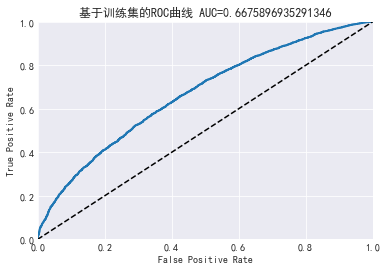

In [278]:
dtrain=xgb.DMatrix(X_train.values,label=y_train.values)
param = {'max_depth': 2, 'eta': 0.05, 'silent': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'
bst0 = xgb.train(params=param, dtrain=dtrain, num_boost_round=200,verbose_eval=False)

y_train_pred_prob = bst0.predict(dtrain)
print("Roc : %.4g" % metrics.roc_auc_score(y_train, y_train_pred_prob))
fpr, tpr, thresholds = roc_curve(y_train, y_train_pred_prob)
auc =  roc_auc_score(y_train, y_train_pred_prob)
def plot_roc_curve(fpr, tpr, ds_type, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("基于{}的ROC曲线 AUC={}".format(ds_type, auc))
plot_roc_curve(fpr, tpr, "训练集")
plt.show()

## 特征重要性分析

### 基于XGBoost

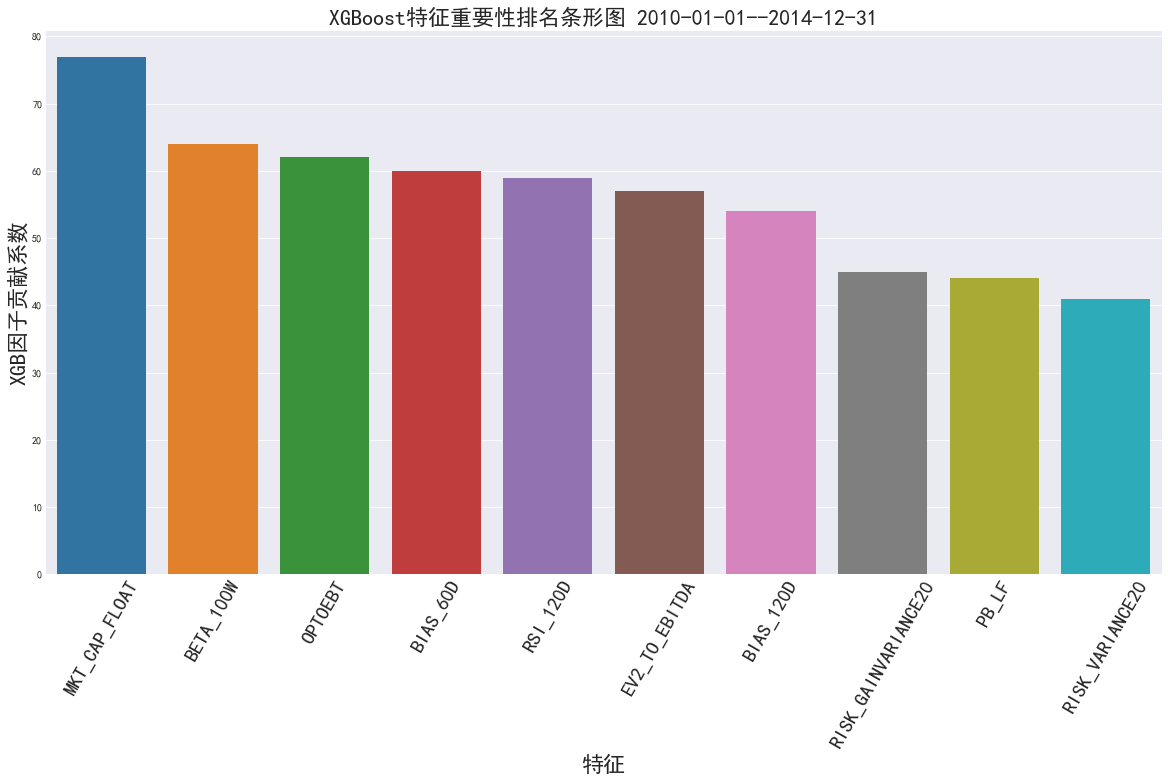

In [187]:
#查看xgboost模型中重要的特征
dtrain=xgb.DMatrix(X_train.values,label=y_train.values)
param = {'max_depth': 2, 'eta': 0.05, 'silent': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'
bst0 = xgb.train(params=param, dtrain=dtrain, num_boost_round=400, verbose_eval=False)
bst0.feature_names = X_train.columns.tolist()
f_importance = bst0.get_fscore()
df_importances_xgb = pd.DataFrame()
df_importances_xgb['features'] = f_importance.keys()
df_importances_xgb['importance'] = f_importance.values()
df_importances_xgb.sort_values(by=['importance'], ascending=False, inplace=True)
fig, ax= plt.subplots()
fig.set_size_inches(20, 10)
plt.title('XGBoost特征重要性排名条形图 {}--{}'.format(ID2DATE[str(DATAID)]['TRAIN'][0], ID2DATE[str(DATAID)]['TRAIN'][1]), fontsize=22) 
plt.xticks(rotation=60)
sns.barplot(data=df_importances_xgb.head(10), x='features', y='importance', ax=ax, orient='v')
plt.xlabel("特征", fontsize=22)
plt.ylabel("XGB因子贡献系数", fontsize=22)
ax.tick_params(axis='x',labelsize=20) # y轴
plt.savefig(r"E:\07_data\02_factor\feature_select\XGBoost_fimp_bar_{}".format(DATAID))
df_importances_xgb = df_importances_xgb.set_index('features')
df_importances_xgb['rank_XGB'] = df_importances_xgb['importance'].rank(ascending=False)
df_importances_xgb.to_csv(r"E:\07_data\02_factor\feature_select\XGB_fimp_{}.csv".format(DATAID))
del df_importances_xgb['importance']

### 基于RF

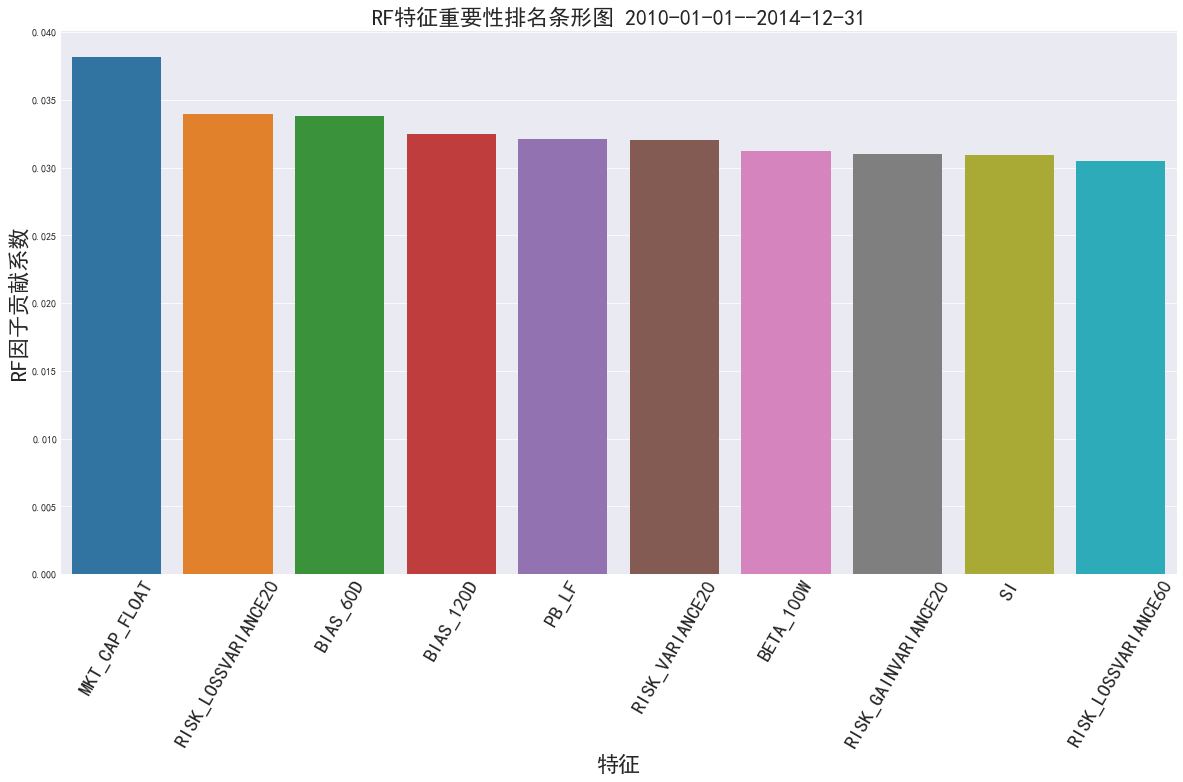

In [188]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train.values.reshape(-1,))
df_importances_rf = pd.DataFrame()
df_importances_rf['features'] = X_train.columns.tolist()
df_importances_rf['importance'] = rf.feature_importances_
df_importances_rf = df_importances_rf.sort_values(['importance'], ascending=False)
fig, ax= plt.subplots()
fig.set_size_inches(20, 10)
plt.title('RF特征重要性排名条形图 {}--{}'.format(ID2DATE[str(DATAID)]['TRAIN'][0], ID2DATE[str(DATAID)]['TRAIN'][1]), fontsize=22)
plt.xticks(rotation=60)
sns.barplot(data=df_importances_rf.head(10), x='features', y='importance', ax=ax, orient='v')
plt.xlabel("特征", fontsize=22)
plt.ylabel("RF因子贡献系数", fontsize=22)
ax.tick_params(axis='x',labelsize=20) # y轴
plt.savefig(r"E:\07_data\02_factor\feature_select\RF_fimp_bar_{}".format(DATAID))
df_importances_rf = df_importances_rf.set_index('features')
df_importances_rf['rank_RF'] = df_importances_rf['importance'].rank(ascending=False)
df_importances_rf.to_csv(r"E:\07_data\02_factor\feature_select\RF_fimp_{}.csv".format(DATAID))
del df_importances_rf['importance']

### 基于GBDT

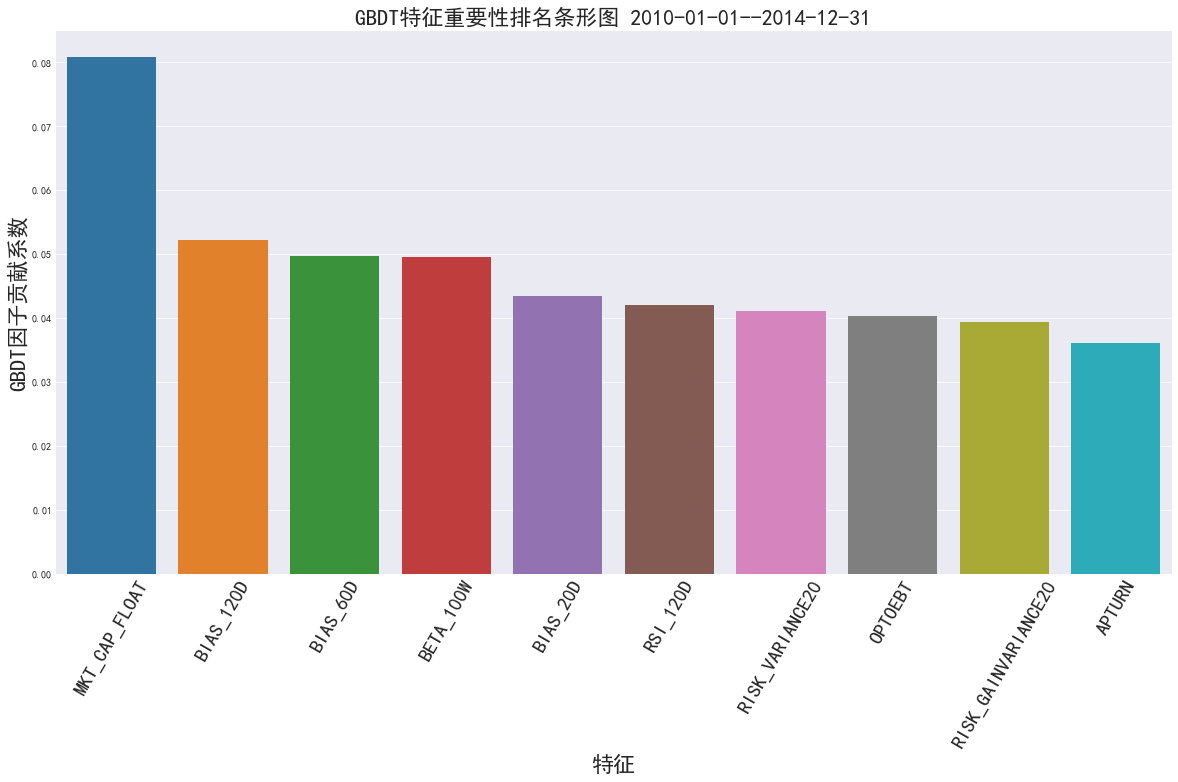

In [189]:
from sklearn.ensemble import GradientBoostingClassifier
gbdt = GradientBoostingClassifier()
gbdt.fit(X_train, y_train.values.reshape(-1,))
df_importances_gbdt = pd.DataFrame()
df_importances_gbdt['features'] = X_train.columns.tolist()
df_importances_gbdt['importance'] = gbdt.feature_importances_
df_importances_gbdt = df_importances_gbdt.sort_values(['importance'], ascending=False)
fig, ax= plt.subplots()
fig.set_size_inches(20, 10)
plt.title('GBDT特征重要性排名条形图 {}--{}'.format(ID2DATE[str(DATAID)]['TRAIN'][0], ID2DATE[str(DATAID)]['TRAIN'][1]), fontsize=22)
plt.xticks(rotation=60)
sns.barplot(data=df_importances_gbdt.head(10), x='features', y='importance', ax=ax, orient='v')
plt.xlabel("特征", fontsize=22)
plt.ylabel("GBDT因子贡献系数", fontsize=22)
ax.tick_params(axis='x',labelsize=20) # y轴
plt.savefig(r"E:\07_data\02_factor\feature_select\GBDT_fimp_bar_{}".format(DATAID))
df_importances_gbdt = df_importances_gbdt.set_index('features')
df_importances_gbdt['rank_GBDT'] = df_importances_gbdt['importance'].rank(ascending=False)
df_importances_gbdt.to_csv(r"E:\07_data\02_factor\feature_select\GBDT_fimp_{}.csv".format(DATAID))
del df_importances_gbdt['importance']

### 相关系数法

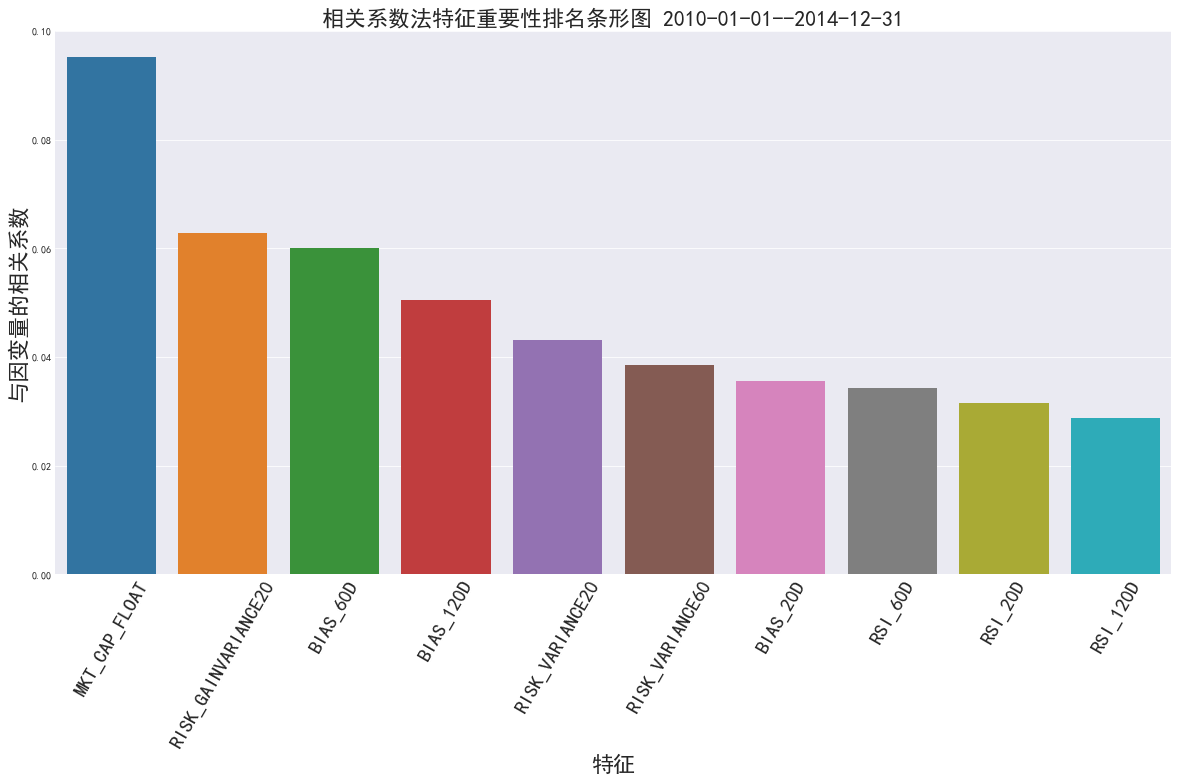

In [190]:
a = np.corrcoef(X_train,y_train, rowvar=0)
df_importances_corr = pd.DataFrame()
df_importances_corr['features'] = X_train.columns.tolist()
df_importances_corr['importance'] = a[:-1, -1]
df_importances_corr['importance'] = np.abs(df_importances_corr['importance'])
df_importances_corr = df_importances_corr.sort_values(['importance'], ascending=False)
fig, ax= plt.subplots()
fig.set_size_inches(20, 10),
plt.title('相关系数法特征重要性排名条形图 {}--{}'.format(ID2DATE[str(DATAID)]['TRAIN'][0], ID2DATE[str(DATAID)]['TRAIN'][1]), fontsize=22)
plt.xticks(rotation=60)
sns.barplot(data=df_importances_corr.head(10), x='features', y='importance', ax=ax, orient='v')
plt.xlabel("特征", fontsize=22)
plt.ylabel("与因变量的相关系数", fontsize=22)
ax.tick_params(axis='x',labelsize=20) # y轴
plt.savefig(r"E:\07_data\02_factor\feature_select\CORR_fimp_bar_{}".format(DATAID))
df_importances_corr = df_importances_corr.set_index('features')
df_importances_corr['rank_corr'] = df_importances_corr['importance'].rank(ascending=False)
df_importances_corr.to_csv(r"E:\07_data\02_factor\feature_select\CORR_fimp_{}.csv".format(DATAID))
del df_importances_corr['importance']

### 单因子有效性检验法

In [14]:
# ID2DATE = {}
# ID2DATE[1] = {"TRAIN": ["2006-01-01", "2010-12-31"], "TEST": ["2011-01-01", "2011-12-31"]}
# ID2DATE[2] = {"TRAIN": ["2007-01-01", "2011-12-31"], "TEST": ["2012-01-01", "2012-12-31"]}
# ID2DATE[3] = {"TRAIN": ["2008-01-01", "2012-12-31"], "TEST": ["2013-01-01", "2013-12-31"]}
# ID2DATE[4] = {"TRAIN": ["2009-01-01", "2013-12-31"], "TEST": ["2014-01-01", "2014-12-31"]}
# ID2DATE[5] = {"TRAIN": ["2010-01-01", "2014-12-31"], "TEST": ["2015-01-01", "2015-12-31"]}
# ID2DATE[6] = {"TRAIN": ["2011-01-01", "2015-12-31"], "TEST": ["2016-01-01", "2016-12-31"]}
# ID2DATE[7] = {"TRAIN": ["2012-01-01", "2016-12-31"], "TEST": ["2017-01-01", "2017-12-31"]} 
# dk.dict2json(ID2DATE, r"E:\07_data\02_factor\ID2DATE.json")

[INFO] 2018-09-09 12:06:39 Dict is saved to E:\07_data\02_factor\ID2DATE.json.


In [19]:
start_date = ID2DATE[DATAID]['TRAIN'][0]
end_date = ID2DATE[DATAID]['TRAIN'][1]
schema = pd.DataFrame(DataAPI.schema.get_schema("indicator")).T
inds_ts = schema[schema.type == '时间序列'].index.tolist()
inds_fr = schema[schema.type == '财报数据'].index.tolist()
trading_days_ts = fk.get_monthly_last_trading_days(start=start_date, end=end_date)
# 流通市值介于LP与UP之间
LP = 0
UP = 1
NEW_CP = 400 # 小于此值为次新股
def dict2df(ind, trading_days):
    df_ind = DataAPI.read.get_secs_indicator_on_multidays(indicator=ind, trading_days=trading_days)
    output = pd.DataFrame()
    for date in df_ind:
        df = df_ind[date]
        df['date'] = date
        output = output.append(df)
    return output
mkt_cap_float = dict2df('MKT_CAP_FLOAT', trading_days_ts)
ipo_listdays = dict2df('IPO_LISTDAYS', trading_days_ts)
low = dict2df('LOW', trading_days_ts)
high = dict2df('HIGH', trading_days_ts)
pe = dict2df('VAL_PE_DEDUCTED_TTM', trading_days_ts)

df_sec_ids = mkt_cap_float.merge(ipo_listdays, how='inner', on=['sec_id', 'date'])
df_sec_ids = df_sec_ids.merge(low, how='inner', on=['sec_id', 'date'])
df_sec_ids = df_sec_ids.merge(high, how='inner', on=['sec_id', 'date'])
df_sec_ids = df_sec_ids.merge(pe, how='inner', on=['sec_id', 'date'])

df_sec_ids = df_sec_ids[df_sec_ids.VAL_PE_DEDUCTED_TTM > 0] # 剔除亏损股票
df_sec_ids = df_sec_ids[df_sec_ids.HIGH != df_sec_ids.LOW] # 剔除停牌股
df_sec_ids = df_sec_ids[df_sec_ids.IPO_LISTDAYS >= NEW_CP] # 剔除次新股

a=df_sec_ids.groupby(['date']).MKT_CAP_FLOAT.quantile(LP).to_frame().reset_index().rename(columns={'MKT_CAP_FLOAT': "size_LP"})
df_sec_ids = df_sec_ids.merge(a, how='inner', on=['date'])
a=df_sec_ids.groupby(['date']).MKT_CAP_FLOAT.quantile(UP).to_frame().reset_index().rename(columns={'MKT_CAP_FLOAT': "size_UP"})
df_sec_ids = df_sec_ids.merge(a, how='inner', on=['date'])

df_sec_ids = df_sec_ids[df_sec_ids.MKT_CAP_FLOAT.between(df_sec_ids['size_LP'], df_sec_ids['size_UP'])]

sec_ids = {}
date_list = list(set(df_sec_ids['date']))
for date in date_list:
    sec_ids[date] = list(df_sec_ids[df_sec_ids['date'] == date]['sec_id'])
    
# 1. 特征
schema = pd.DataFrame(DataAPI.schema.get_schema("indicator")).T
schema = schema[~schema.aspect.isin(['辅助指标', '价量指标'])]
inds_ts = schema[schema.type == '时间序列'].index.tolist()
# 这几个特征暂时没取完 为了避免下面的读写错误 先删除这个变量
# inds_ts.remove('RSI_60D')
# inds_ts.remove('RSI_120D')
# inds_ts.remove('RSI_20D')
# inds_ts.remove('SI')
# inds_ts.remove("USDX")
# inds_ts.remove("USDCNY")
# inds_ts.remove("DR001")
# inds_ts.remove("DR007")
# inds_ts.remove("SHIBORON")
# inds_ts.remove("TB1Y")
# inds_ts.remove("TB5Y")
# inds_ts.remove("TB10Y")
# inds_ts.remove("LPR1Y") 
inds_ts.remove('TECH_CRY')
inds_ts.remove('TECH_MAWVAD')
inds_ts.remove('TECH_PSY')
inds_ts.remove('TECH_REVS10')
inds_ts.remove('TECH_REVS120')
inds_ts.remove('TECH_REVS20INDU1')
inds_ts.remove('TECH_REVS250')
inds_ts.remove('TECH_REVS5')
inds_ts.remove('TECH_REVS5INDU1')
inds_ts.remove('TECH_REVS60')
inds_ts.remove('TECH_REVS750')
inds_ts.remove('TECH_TURNOVERRATE120')
inds_ts.remove('TECH_TURNOVERRATE240')
inds_ts.remove('TECH_TURNOVERRATE5')
inds_ts.remove('TECH_TURNOVERRATE20')
inds_ts.remove("TECH_TURNOVERRATE60")
inds_fr = schema[schema.type == '财报数据'].index.tolist()
# 时间序列指标
df_inds=pd.DataFrame()
for ind in inds_ts:
    df_ind = pd.DataFrame()
    for date in trading_days_ts:   
        a = DataAPI.read.get_secs_indicator(indicator=ind, sec_ids=sec_ids[date], date=date).reset_index()
        a['date'] = date
        df_ind = df_ind.append(a)
    if len(df_inds) == 0:
        df_inds = df_ind.copy()
    else:
        df_inds = df_inds.merge(df_ind, how='outer', on=['sec_id', 'date'])
        
df_inds['date_available'] = df_inds['date'].apply(lambda x: dk.get_available_report_day(x))

# 财务报表指标
report_days_to_load = list(set(df_inds['date_available']))
secs_list_temp = list(set(df_inds['sec_id']))  # 由于财报数据取报告日 为了保证所有需要股票都取到 取时间序列指标各月末入选股票的并集
df_frs=pd.DataFrame()
for ind in inds_fr:
    df_fr = pd.DataFrame()
    for date in report_days_to_load:
        a = DataAPI.read.get_secs_indicator(indicator=ind, sec_ids=secs_list_temp, date=date).reset_index()
        a['date'] = date
        df_fr = df_fr.append(a)
    if len(df_frs) == 0:
        df_frs = df_fr.copy()
    else:
        df_frs = df_frs.merge(df_fr, how='outer', on=['sec_id', 'date'])
df_frs = df_frs.rename(columns={'date': 'date_available'})
df_inds = df_inds.merge(df_frs, how='left', on=['sec_id', 'date_available'])
df_inds['yearmonth'] = df_inds['date'].apply(lambda x: dk.date2char(dk.char2datetime(x) +  dk.timedelta({'months': 1}))[:7])
def derive_next_month_rr(sec_ids):
    """
    获取给定股票列表在给定日期列表的下个月收益率
    @sec_ids <list>: 股票列表
    """
    # 取月初月末的交易日列表
    tds = pd.read_csv(r"E:\07_data\02_factor\temp_data\trading_days.csv")
    tds['group'] = tds['date'].apply(lambda x: x[:7])
    tds = tds.sort_values(['date'])
    first = tds.groupby('group').head(1)
    last = tds.groupby('group').tail(1)
    tds=first.append(last)
    tds = tds.sort_values('date')

    # 获取月初月末交易日的收盘价
    close = factor.get_secs_index(index="close", trading_days=tds.date.tolist(), sec_ids=sec_ids)
    close = close.sort_values(['sec_id', 'date'])
    close['yearmonth'] = close['date'].apply(lambda x: x[:7])

    # 获取月收益率
    def cal_ret(x):
        close_id = x.columns.tolist().index('close')
        return x.iloc[-1, close_id]/x.iloc[0, close_id] - 1
    df_target=close.groupby(['sec_id', 'yearmonth'], as_index=False).apply(lambda x: cal_ret(x))
    df_target=df_target.reset_index().rename(columns={0: 'month_ret'})
    return df_target

df_target = derive_next_month_rr(list(set(df_inds['sec_id'])))

df_raw=df_inds.merge(df_target, how='inner', on=['sec_id', 'yearmonth'])

# 删除缺失过多的特征 然后删除缺失样本
def drop_overmissing_feats(dsi, threshold):
    """
    删除缺失过多的特征  然后剔除有缺失值的样本
    """
    a = dsi.isnull().sum() / len(dsi) < threshold
    feats_to_retain = a[a].index
    dsi = dsi[feats_to_retain].dropna()
    dsi = dsi.reset_index()
    del dsi['index']
    return dsi
    # del df_raw['sec_id']
    # del train['group_id']
df_raw = drop_overmissing_feats(df_raw, 0.1)
# df_raw.to_csv((r"E:\07_data\02_factor\temp_data\factor_test.csv"))
# df_raw = pd.read_csv(r"E:\07_data\02_factor\temp_data\factor_test.csv", index_col=0)
df_raw['date_num'] = pd.to_datetime(df_raw['date'])

# 删除缺失过多的特征 然后删除缺失样本
def drop_overmissing_feats(dsi, threshold):
    """
    删除缺失过多的特征  然后剔除有缺失值的样本
    """
    a = dsi.isnull().sum() / len(dsi) < threshold
    feats_to_retain = a[a].index
    dsi = dsi[feats_to_retain].dropna()
    dsi = dsi.reset_index()
    del dsi['index']
    return dsi
    # del df_raw['sec_id']
    # del train['group_id']
df_raw1 = drop_overmissing_feats(df_raw, 0.1)
feats = list(df_raw1.columns[1:-3])
feats.remove('date')
feats.remove('date_available')

from scipy import stats

ttest = {}
for feat in feats:
    print(feat)
    df_factor_test = df_raw1[['date', 'date_num', 'sec_id', feat, 'month_ret']]
    datelist = list(set(df_factor_test['date']))
    df_ret_by_group = pd.DataFrame()
    for date in datelist:
        close = factor.get_secs_index(index="close", trading_days=[date], sec_ids=df_raw1.sec_id.tolist())
        a = df_factor_test.merge(close, how='inner', on=['date', 'sec_id'])
        a = a[a['date'] == date]
        lower, upper = a[feat].quantile([0.05, 0.95])
        a = a[(a[feat] >= lower) & (a[feat] <= upper)]
        a = a.sort_values(by=feat)
        a["group"] = np.nan  # 表示缺失
        group_num = 10
        n_sample = a.shape[0]
        dist = int(n_sample / group_num)  # 每组个数
        col_index = a.columns.tolist().index("group")
        for j in range(group_num):
            if j < group_num - 1:
                a.iloc[j * dist:(j + 1) * dist, col_index] = j
            else:
                a.iloc[j * dist:, col_index] = j

        a['close_ending'] = a['close'] * (a['month_ret'] + 1)
        b = a.groupby(['group']).apply(lambda x: x['close_ending'].sum() / x['close'].sum() - 1).to_frame()
        b = b.transpose()
        b.columns = ['group{:0>2}'.format(i) for i in range(1, group_num + 1)]
        b[feat] = b['group10'] - b['group01']
        b['date'] = date
        df_ret_by_group = df_ret_by_group.append(b)
    ttest[feat] =  stats.ttest_rel(df_ret_by_group['group10'], df_ret_by_group['group01'])[1]
    df_ret_by_group['date_num'] = pd.to_datetime(df_ret_by_group['date'])
    df_ret_by_group = df_ret_by_group.set_index('date_num')
    df_ret_by_group = df_ret_by_group.sort_index()
    fig = plt.figure(figsize=(12, 6))
    ax = plt.subplot(111)
    df_ret_by_group[['group01', 'group10']].cumsum().plot(ax=ax)
    ax.set_title("{}累计收益".format(feat))
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    picfile = os.path.join(r"E:\07_data\02_factor\plot", "{}.png".format(feat))
    plt.savefig(picfile)
    print("plot is saved to: {}".format(picfile))
    
df_importances_ttest = pd.DataFrame([[k,v] for k,v in ttest.items()], columns=['features', 'importance'])
df_importances_ttest['importance'] = 1 - df_importances_ttest['importance'] # p值越小越好 所以1-p越大越好
df_importances_ttest = df_importances_ttest.sort_values(['importance'], ascending=0)
fig, ax= plt.subplots()
fig.set_size_inches(20, 10)
plt.title('单因子分层有效性检验特征重要性排名条形图', fontsize=22)
plt.xticks(rotation=60)
sns.barplot(data=df_importances_ttest.head(10), x='features', y='importance', ax=ax, orient='v')
plt.xlabel("特征", fontsize=22)
plt.ylabel("单因子分层有效性检验因子贡献系数", fontsize=22)
ax.tick_params(axis='x',labelsize=20) # y轴
df_importances_ttest = df_importances_ttest.set_index('features')
df_importances_ttest['rank_ttest'] = df_importances_ttest['importance'].rank()
df_importances_ttest.to_csv(r"E:\07_data\02_factor\TTEST_fimp_{}.csv".format(DATAID))
del df_importances_ttest['importance']

KeyError: 5

### 综合评估

In [191]:
df_feats_imp = (df_importances_xgb['rank_XGB'] + df_importances_rf['rank_RF'] + df_importances_gbdt['rank_GBDT']) 
selected_feats = df_feats_imp.sort_values()[:20].index.tolist()
f = open(r"E:\07_data\02_factor\feature_select\selected_feats_{}.txt".format(DATAID), 'wb')
pickle.dump( selected_feats, f, 0 )
f.close()

## 筛选特征后未调参建模

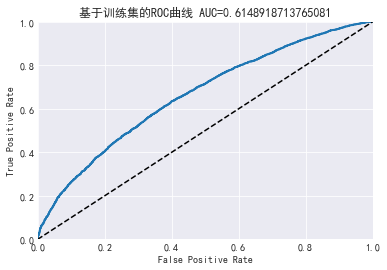

In [192]:
f = open(r"E:\07_data\02_factor\feature_select\selected_feats_{}.txt".format(DATAID), 'rb')
selected_feats = pickle.load(f)
X_train = X_train[selected_feats]
dtrain=xgb.DMatrix(X_train.values,label=y_train.values)
param = {'max_depth': 2, 'eta': 0.05, 'silent': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'
bst0 = xgb.train(params=param, dtrain=dtrain, num_boost_round=200,verbose_eval=False)
bst0.save_model(r"E:\07_data\02_factor\model\bst0_{}.model".format(DATAID))
y_train_pred_prob = bst0.predict(dtrain)
fpr, tpr, thresholds = roc_curve(y_train, y_train_pred_prob)
auc =  roc_auc_score(y_train, y_train_pred)
def plot_roc_curve(fpr, tpr, ds_type, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("基于{}的ROC曲线 AUC={}".format(ds_type, auc))
plot_roc_curve(fpr, tpr, "训练集")
plt.show()

## XGB调参-网格法

In [187]:
# 确定最优基学习器个数
xgb_param = {"booster": "gbtree", "objective": "binary:logistic", "silent": 1, "eval_metric": "auc"}
X_train1, X_train2, y_train1, y_train2 = train_test_split(X_train, y_train, test_size=0.5, random_state=30)
dtrain=xgb.DMatrix(X_train1.values,label=y_train1.values)
dtest=xgb.DMatrix(X_train2.values,label=y_train2.values)
watchlist = [(dtest, 'eval'), (dtrain, 'train')]
num_round = 1000
bst = xgb.train(xgb_param, dtrain, num_round, watchlist, early_stopping_rounds=50, verbose_eval=False)
best_n_estimators = bst.best_ntree_limit
print("最优基学习器个数: ", best_n_estimators)
# y_pred_prob = bst.predict(dtest)
# labels = dtest.get_label()
# y_pred = [1 if i > 0.5 else 0 for i in y_pred_prob]
# res2.append(roc_auc_score(labels, y_pred_prob))

最优基学习器个数:  164


In [188]:
# 调节树的深度
res1_1 = {}
for max_depth in range(1, 10, 1):
    res2_1 = []
    for seed in np.random.randint(1, 100, 5):
        xgb_param = {"booster": "gbtree", "objective": "binary:logistic", "silent": 1,
                 "eta": 0.2, "gamma": 0, "max_depth": max_depth, "min_child_weight": 1, "reg_alpha": 0, "reg_lambda": 1,
                "subsample": 0.8, "colsample_bytree": 0.8}
        X_train1, X_train2, y_train1, y_train2 = train_test_split(X_train, y_train, test_size=0.5, random_state=seed)
        dtrain=xgb.DMatrix(X_train1.values,label=y_train1.values)
        dtest=xgb.DMatrix(X_train2.values,label=y_train2.values)
        watchlist = [(dtest, 'eval'), (dtrain, 'train')]
        bst = xgb.train(xgb_param, dtrain, best_n_estimators, watchlist, verbose_eval=False)
        y_pred_prob = bst.predict(dtest)
        labels = dtest.get_label()
        y_pred = [1 if i > 0.5 else 0 for i in y_pred_prob]
        res2_1.append(metrics.roc_auc_score(labels, y_pred_prob))
    res1_1[max_depth] = np.mean(res2_1)
a = sorted(res1_1.items(),key=lambda x: x[1])[-1]
best_max_depth = a[0]
print("max_depth={}最优, 最优情况下在测试集的5次平均AUC为{}".format(best_max_depth, a[1]))

max_depth=1最优, 最优情况下在测试集的5次平均AUC为0.580884545287296


In [189]:
# 调节min_child_weight
res2_1 = {}
for min_child_weight in range(1, 20, 4):
    res2_2 = []
    for seed in np.random.randint(1, 100, 5):
        xgb_param = {"booster": "gbtree", "objective": "binary:logistic", "silent": 1,
                 "eta": 0.2, "gamma": 0, "max_depth": best_max_depth, "min_child_weight": min_child_weight, "reg_alpha": 0, "reg_lambda": 1,
                "subsample": 0.8, "colsample_bytree": 0.8}
        X_train1, X_train2, y_train1, y_train2 = train_test_split(X_train, y_train, test_size=0.5, random_state=seed)
        dtrain=xgb.DMatrix(X_train1.values,label=y_train1.values)
        dtest=xgb.DMatrix(X_train2.values,label=y_train2.values)
        watchlist = [(dtest, 'eval'), (dtrain, 'train')]
        bst = xgb.train(xgb_param, dtrain, best_n_estimators, watchlist, verbose_eval=False)
        y_pred_prob = bst.predict(dtest)
        labels = dtest.get_label()
        y_pred = [1 if i > 0.5 else 0 for i in y_pred_prob]
        res2_2.append(metrics.roc_auc_score(labels, y_pred_prob))
    res2_1[max_depth] = np.mean(res2_2)
a = sorted(res2_1.items(),key=lambda x: x[1])[-1]
best_min_child_weight = a[0]
print("min_child_weight={}最优, 最优情况下在测试集的5次平均AUC为{}".format(best_min_child_weight, a[1]))

min_child_weight=9最优, 最优情况下在测试集的5次平均AUC为0.5828639080553695


In [190]:
# 调节gamma
res3_1 = {}
for gamma in np.arange(1, 20, 4):
    res3_2 = []
    for seed in np.random.randint(1, 100, 5):
        xgb_param = {"booster": "gbtree", "objective": "binary:logistic", "silent": 1,
                 "eta": 0.2, "gamma": gamma, "max_depth": best_max_depth, "min_child_weight": best_min_child_weight,
                "reg_alpha": 0, "reg_lambda": 1,
                "subsample": 0.8, "colsample_bytree": 0.8}
        X_train1, X_train2, y_train1, y_train2 = train_test_split(X_train, y_train, test_size=0.5, random_state=seed)
        dtrain=xgb.DMatrix(X_train1.values,label=y_train1.values)
        dtest=xgb.DMatrix(X_train2.values,label=y_train2.values)
        watchlist = [(dtest, 'eval'), (dtrain, 'train')]
        bst = xgb.train(xgb_param, dtrain, best_n_estimators, watchlist, verbose_eval=False)
        y_pred_prob = bst.predict(dtest)
        labels = dtest.get_label()
        y_pred = [1 if i > 0.5 else 0 for i in y_pred_prob]
        res3_2.append(metrics.roc_auc_score(labels, y_pred_prob))
    res3_1[gamma] = np.mean(res3_2)
a = sorted(res3_1.items(),key=lambda x: x[1])[-1]
best_gamma = a[0]
print("gamma={}最优, 最优情况下在测试集的5次平均AUC为{}".format(best_gamma, a[1]))

gamma=5最优, 最优情况下在测试集的5次平均AUC为0.5832980685029423


In [191]:
# 调节subsample 
res4_1 = {}
for subsample in np.arange(0.45, 0.86, 0.1):
    res4_2 = []
    for seed in np.random.randint(1, 100, 5):
        xgb_param = {"booster": "gbtree", "objective": "binary:logistic", "silent": 1,
                 "eta": 0.2, "gamma": best_gamma, "max_depth": best_max_depth, "min_child_weight": best_min_child_weight,
                "reg_alpha": 0, "reg_lambda": 1,
                "subsample": subsample, "colsample_bytree": 0.8}
        X_train1, X_train2, y_train1, y_train2 = train_test_split(X_train, y_train, test_size=0.5, random_state=seed)
        dtrain=xgb.DMatrix(X_train1.values,label=y_train1.values)
        dtest=xgb.DMatrix(X_train2.values,label=y_train2.values)
        watchlist = [(dtest, 'eval'), (dtrain, 'train')]
        bst = xgb.train(xgb_param, dtrain, best_n_estimators, watchlist, verbose_eval=False)
        y_pred_prob = bst.predict(dtest)
        labels = dtest.get_label()
        y_pred = [1 if i > 0.5 else 0 for i in y_pred_prob]
        res4_2.append(metrics.roc_auc_score(labels, y_pred_prob))
    res4_1[subsample] = np.mean(res4_2)
a = sorted(res4_1.items(),key=lambda x: x[1])[-1]
best_subsample = a[0]
print("subsample={}最优, 最优情况下在测试集的5次平均AUC为{}".format(best_subsample, a[1]))

subsample=0.8500000000000001最优, 最优情况下在测试集的5次平均AUC为0.584129375223617


In [192]:
# 调节colsample_bytree
res5_1 = {}
for colsample_bytree in np.arange(0.1, 1.01, 0.1):
    res5_2 = []
    for seed in np.random.randint(1, 100, 5):
        xgb_param = {"booster": "gbtree", "objective": "binary:logistic", "silent": 1,
                 "eta": 0.2, "gamma": best_gamma, "max_depth": best_max_depth, "min_child_weight": best_min_child_weight,
                "reg_alpha": 0, "reg_lambda": 1,
                "subsample": best_subsample, "colsample_bytree": colsample_bytree}
        X_train1, X_train2, y_train1, y_train2 = train_test_split(X_train, y_train, test_size=0.33, random_state=seed)
        dtrain=xgb.DMatrix(X_train1.values,label=y_train1.values)
        dtest=xgb.DMatrix(X_train2.values,label=y_train2.values)
        watchlist = [(dtest, 'eval'), (dtrain, 'train')]
        bst = xgb.train(xgb_param, dtrain, best_n_estimators, watchlist, verbose_eval=False)
        y_pred_prob = bst.predict(dtest)
        labels = dtest.get_label()
        y_pred = [1 if i > 0.5 else 0 for i in y_pred_prob]
        res5_2.append(metrics.roc_auc_score(labels, y_pred_prob))
    res5_1[colsample_bytree] = np.mean(res5_2)
a = sorted(res5_1.items(),key=lambda x: x[1])[-1]
best_colsample_bytree = a[0]
print("colsample_bytree={}最优, 最优情况下在测试集的5次平均AUC为{}".format(best_colsample_bytree, a[1]))

colsample_bytree=0.2最优, 最优情况下在测试集的5次平均AUC为0.5872138861024261


In [194]:
# 调节reg_alpha
res6_1 = {}
for reg_alpha in [0.0001, 0.001, 0.01, 0.1, 1]:
    res6_2 = []
    for seed in np.random.randint(1, 100, 5):
        xgb_param = {"booster": "gbtree", "objective": "binary:logistic", "silent": 1,
                 "eta": 0.2, "gamma": best_gamma, "max_depth": best_max_depth, "min_child_weight": best_min_child_weight,
                "reg_alpha": reg_alpha, "reg_lambda": 1,
                "subsample": best_subsample, "colsample_bytree": best_colsample_bytree}
        X_train1, X_train2, y_train1, y_train2 = train_test_split(X_train, y_train, test_size=0.33, random_state=seed)
        dtrain=xgb.DMatrix(X_train1.values,label=y_train1.values)
        dtest=xgb.DMatrix(X_train2.values,label=y_train2.values)
        watchlist = [(dtest, 'eval'), (dtrain, 'train')]
        bst = xgb.train(xgb_param, dtrain, best_n_estimators, watchlist, verbose_eval=False)
        y_pred_prob = bst.predict(dtest)
        labels = dtest.get_label()
        y_pred = [1 if i > 0.5 else 0 for i in y_pred_prob]
        res6_2.append(metrics.roc_auc_score(labels, y_pred_prob))
    res6_1[reg_alpha] = np.mean(res6_2)
a = sorted(res6_1.items(),key=lambda x: x[1])[-1]
best_reg_alpha = a[0]
print("reg_alpha={}最优, 最优情况下在测试集的5次平均AUC为{}".format(best_reg_alpha, a[1]))

reg_alpha=0.1最优, 最优情况下在测试集的5次平均AUC为0.5893366378701275


In [198]:
# 调节reg_lambda
res7_1 = {}
for reg_lambda in [0.0001, 0.001, 0.01, 0.1, 1]:
    res7_2 = []
    for seed in np.random.randint(1, 100, 5):
        xgb_param = {"booster": "gbtree", "objective": "binary:logistic", "silent": 1,
                 "eta": 0.2, "gamma": best_gamma, "max_depth": best_max_depth, "min_child_weight": best_min_child_weight,
                "reg_alpha": best_reg_alpha, "reg_lambda": reg_lambda,
                "subsample": best_subsample, "colsample_bytree": best_colsample_bytree}
        X_train1, X_train2, y_train1, y_train2 = train_test_split(X_train, y_train, test_size=0.33, random_state=seed)
        dtrain=xgb.DMatrix(X_train1.values,label=y_train1.values)
        dtest=xgb.DMatrix(X_train2.values,label=y_train2.values)
        watchlist = [(dtest, 'eval'), (dtrain, 'train')]
        bst = xgb.train(xgb_param, dtrain, best_n_estimators, watchlist, verbose_eval=False)
        y_pred_prob = bst.predict(dtest)
        labels = dtest.get_label()
        y_pred = [1 if i > 0.5 else 0 for i in y_pred_prob]
        res7_2.append(metrics.roc_auc_score(labels, y_pred_prob))
    res7_1[reg_lambda] = np.mean(res7_2)
a = sorted(res7_1.items(),key=lambda x: x[1])[-1]
best_reg_lambda = a[0]
print("reg_lambda={}最优, 最优情况下在测试集的5次平均AUC为{}".format(best_reg_lambda, a[1]))

reg_lambda=0.1最优, 最优情况下在测试集的5次平均AUC为0.5875951656873429


In [200]:
# 调节eta
res8_1 = {}
for eta in np.arange(0.1, 1, 0.1):
    res8_2 = []
    for seed in np.random.randint(1, 100, 5):
        xgb_param = {"booster": "gbtree", "objective": "binary:logistic", "silent": 1,
                 "eta": eta, "gamma": best_gamma, "max_depth": best_max_depth, "min_child_weight": best_min_child_weight,
                "reg_alpha": best_reg_alpha, "reg_lambda": best_reg_lambda,
                "subsample": best_subsample, "colsample_bytree": best_colsample_bytree}
        X_train1, X_train2, y_train1, y_train2 = train_test_split(X_train, y_train, test_size=0.33, random_state=seed)
        dtrain=xgb.DMatrix(X_train1.values,label=y_train1.values)
        dtest=xgb.DMatrix(X_train2.values,label=y_train2.values)
        watchlist = [(dtest, 'eval'), (dtrain, 'train')]
        bst = xgb.train(xgb_param, dtrain, best_n_estimators, watchlist, verbose_eval=False)
        y_pred_prob = bst.predict(dtest)
        labels = dtest.get_label()
        y_pred = [1 if i > 0.5 else 0 for i in y_pred_prob]
        res8_2.append(metrics.roc_auc_score(labels, y_pred_prob))
    res8_1[eta] = np.mean(res8_2)
a = sorted(res8_1.items(),key=lambda x: x[1])[-1]
best_eta = a[0]
print("eta={}最优, 最优情况下在测试集的5次平均AUC为{}".format(best_eta, a[1]))

eta=0.2最优, 最优情况下在测试集的5次平均AUC为0.5874658225524396


## XGB调参-GA法

In [202]:
import numpy as np
from scipy.optimize import fsolve, basinhopping
import random
import timeit


# 根据解的精度确定染色体(chromosome)的长度
# 需要根据决策变量的上下边界来确定
def getEncodedLength(delta=0.0001, boundarylist=[]):
    # 每个变量的编码长度
    lengths = []
    for i in boundarylist:
        lower = i[0]
        upper = i[1]
        # lamnda 代表匿名函数f(x)=0,50代表搜索的初始解
        res = fsolve(lambda x: ((upper - lower) * 1 / delta) - 2 ** x - 1, 50)
        length = int(np.floor(res[0]))
        lengths.append(length)
    return lengths
    pass


# 随机生成初始编码种群
def getIntialPopulation(encodelength, populationSize):
    # 随机化初始种群为0
    chromosomes = np.zeros((populationSize, sum(encodelength)), dtype=np.uint8)
    for i in range(populationSize):
        chromosomes[i, :] = np.random.randint(0, 2, sum(encodelength))
    # print('chromosomes shape:', chromosomes.shape)
    return chromosomes


# 染色体解码得到表现型的解
def decodedChromosome(encodelength, chromosomes, boundarylist, delta=0.0001):
    populations = chromosomes.shape[0]
    variables = len(encodelength)
    decodedvalues = np.zeros((populations, variables))
    for k, chromosome in enumerate(chromosomes):
        chromosome = chromosome.tolist()
        start = 0
        for index, length in enumerate(encodelength):
            # 将一个染色体进行拆分，得到染色体片段
            power = length - 1
            # 解码得到的10进制数字
            demical = 0
            for i in range(start, length + start):
                demical += chromosome[i] * (2 ** power)
                power -= 1
            lower = boundarylist[index][0]
            upper = boundarylist[index][1]
            decodedvalue = lower + demical * (upper - lower) / (2 ** length - 1)
            decodedvalues[k, index] = decodedvalue
            # 开始去下一段染色体的编码
            start = length
    return decodedvalues


# 得到个体的适应度值及每个个体被选择的累积概率
def getFitnessValue(func, chromosomesdecoded):
    # 得到种群规模和决策变量的个数
    population, nums = chromosomesdecoded.shape
    # 初始化种群的适应度值为0
    fitnessvalues = np.zeros((population, 1))
    # 计算适应度值
    for i in range(population):
        fitnessvalues[i, 0] = func(chromosomesdecoded[i, :])
    # 计算每个染色体被选择的概率
    probability = fitnessvalues / np.sum(fitnessvalues)
    # 得到每个染色体被选中的累积概率
    cum_probability = np.cumsum(probability)
    return fitnessvalues, cum_probability


# 新种群选择
def selectNewPopulation(chromosomes, cum_probability):
    m, n = chromosomes.shape
    newpopulation = np.zeros((m, n), dtype=np.uint8)
    # 随机产生M个概率值
    randoms = np.random.rand(m)
    for i, randoma in enumerate(randoms):
        logical = cum_probability >= randoma
        index = np.where(logical == 1)
        # index是tuple,tuple中元素是ndarray
        newpopulation[i, :] = chromosomes[index[0][0], :]
    return newpopulation
    pass


# 新种群交叉
def crossover(population, Pc=0.8):
    """
    :param population: 新种群
    :param Pc: 交叉概率默认是0.8
    :return: 交叉后得到的新种群
    """
    # 根据交叉概率计算需要进行交叉的个体个数
    m, n = population.shape
    numbers = np.uint8(m * Pc)
    # 确保进行交叉的染色体个数是偶数个
    if numbers % 2 != 0:
        numbers += 1
    # 交叉后得到的新种群
    updatepopulation = np.zeros((m, n), dtype=np.uint8)
    # 产生随机索引
    index = random.sample(range(m), numbers)
    # 不进行交叉的染色体进行复制
    for i in range(m):
        if not index.__contains__(i):
            updatepopulation[i, :] = population[i, :]
    # crossover
    while len(index) > 0:
        a = index.pop()
        b = index.pop()
        # 随机产生一个交叉点
        crossoverPoint = random.sample(range(1, n), 1)
        crossoverPoint = crossoverPoint[0]
        # one-single-point crossover
        updatepopulation[a, 0:crossoverPoint] = population[a, 0:crossoverPoint]
        updatepopulation[a, crossoverPoint:] = population[b, crossoverPoint:]
        updatepopulation[b, 0:crossoverPoint] = population[b, 0:crossoverPoint]
        updatepopulation[b, crossoverPoint:] = population[a, crossoverPoint:]
    return updatepopulation
    pass


# 染色体变异
def mutation(population, Pm=0.01):
    """
    :param population: 经交叉后得到的种群
    :param Pm: 变异概率默认是0.01
    :return: 经变异操作后的新种群
    """
    updatepopulation = np.copy(population)
    m, n = population.shape
    # 计算需要变异的基因个数
    gene_num = np.uint8(m * n * Pm)
    # 将所有的基因按照序号进行10进制编码，则共有m*n个基因
    # 随机抽取gene_num个基因进行基本位变异
    mutationGeneIndex = random.sample(range(0, m * n), gene_num)
    # 确定每个将要变异的基因在整个染色体中的基因座(即基因的具体位置)
    for gene in mutationGeneIndex:
        # 确定变异基因位于第几个染色体
        chromosomeIndex = gene // n
        # 确定变异基因位于当前染色体的第几个基因位
        geneIndex = gene % n
        # mutation
        if updatepopulation[chromosomeIndex, geneIndex] == 0:
            updatepopulation[chromosomeIndex, geneIndex] = 1
        else:
            updatepopulation[chromosomeIndex, geneIndex] = 0
    return updatepopulation
    pass


# 定义适应度函数
# def fitnessFunction():
#	return lambda x: 21.5 + x[0] * np.sin(4 * np.pi * x[0]) + x[1] * np.sin(20 * np.pi * x[1])
#	pass
def get_cv_score(params, X, y, nfolds, test_size=0.33):
    res = []
    for seed in np.random.randint(1, 100, nfolds):
        xgb_param = {"booster": "gbtree", "objective": "binary:logistic", "silent": 1,
                     "max_depth": 8, "min_child_weight": 9,
                     "gamma": params[0], "subsample": params[1], "colsample_bytree": params[2],
                     "reg_alpha": params[3], "reg_lambda": params[4], "eta": params[5]}
        X_train1, X_train2, y_train1, y_train2 = train_test_split(X, y, test_size=test_size, random_state=seed)
        dtrain = xgb.DMatrix(X_train1.values, label=y_train1.values)
        dtest = xgb.DMatrix(X_train2.values, label=y_train2.values)
        watchlist = [(dtest, 'eval'), (dtrain, 'train')]
        bst = xgb.train(xgb_param, dtrain, 216, watchlist, verbose_eval=False)
        y_pred_prob = bst.predict(dtest)
        labels = dtest.get_label()
        y_pred = [1 if i > 0.5 else 0 for i in y_pred_prob]
        res.append(metrics.roc_auc_score(labels, y_pred_prob))
    return np.mean(res)


def fitnessFunction(x):
    return get_cv_score(params=x, X=X_train, y=y_train, nfolds=1)


def main(max_iter=500):
    # 每次迭代得到的最优解
    optimalSolutions = []
    optimalValues = []
    # 决策变量的取值范围
    # gamma, subsample, colsample_bytree, reg_alpha, reg_lambda, learning_rate'
    decisionVariables = [3, 7], [0.7, 0.9], [0.1, 0.3], [0.05, 0.15], [0.05, 0.15], [0.1, 0.4]
    # 得到染色体编码长度
    lengthEncode = getEncodedLength(boundarylist=decisionVariables)
    for iteration in range(max_iter):
        print(iteration)
        # 得到初始种群编码
        chromosomesEncoded = getIntialPopulation(lengthEncode, 5)
        # 种群解码
        decoded = decodedChromosome(lengthEncode, chromosomesEncoded, decisionVariables)
        # 得到个体适应度值和个体的累积概率
        evalvalues, cum_proba = getFitnessValue(fitnessFunction, decoded)
        print("当前种群最好效果：AUC={}".format(evalvalues.max()))
        # 选择新的种群
        newpopulations = selectNewPopulation(chromosomesEncoded, cum_proba)
        # 进行交叉操作
        crossoverpopulation = crossover(newpopulations)
        # mutation
        mutationpopulation = mutation(crossoverpopulation)
        # 将变异后的种群解码，得到每轮迭代最终的种群
        final_decoded = decodedChromosome(lengthEncode, mutationpopulation, decisionVariables)
        
        # 适应度评价
        fitnessvalues, cum_individual_proba = getFitnessValue(fitnessFunction, final_decoded)
        # 搜索每次迭代的最优解，以及最优解对应的目标函数的取值
        optimalValues.append(np.max(list(fitnessvalues)))
        index = np.where(fitnessvalues == max(list(fitnessvalues)))
        optimalSolutions.append(final_decoded[index[0][0], :])
    # 搜索最优解
    optimalValue = np.max(optimalValues)
    optimalIndex = np.where(optimalValues == optimalValue)
    optimalSolution = optimalSolutions[optimalIndex[0][0]]
    return optimalSolution, optimalValue

In [203]:
solution, value = main(max_iter=50)
print('最优解: gamma, subsample, colsample_bytree, reg_alpha, reg_lambda, learning_rate')
print(solution[0], solution[1], solution[2], solution[3], solution[4], solution[5])
print('最优目标函数值:', value)
# # 测量运行时间
# elapsedtime = timeit.timeit(stmt=main, number=1)
# print('Searching Time Elapsed:(S)', elapsedtime)


0
当前种群最好效果：AUC=0.570003156366391
1
当前种群最好效果：AUC=0.5739939735205246
2
当前种群最好效果：AUC=0.5707656036415791
3
当前种群最好效果：AUC=0.577933557714811
4
当前种群最好效果：AUC=0.5809662848832997
5
当前种群最好效果：AUC=0.5732530315183642
6
当前种群最好效果：AUC=0.5718395376637371
7
当前种群最好效果：AUC=0.5758545003051411
8
当前种群最好效果：AUC=0.5609532230221885
9
当前种群最好效果：AUC=0.5738939040043769
10
当前种群最好效果：AUC=0.5742883453450571
11
当前种群最好效果：AUC=0.5730814268192383
12
当前种群最好效果：AUC=0.5744484149031095
13
当前种群最好效果：AUC=0.5691379316149537
14
当前种群最好效果：AUC=0.5738653531980866
15
当前种群最好效果：AUC=0.5579882177271105
16
当前种群最好效果：AUC=0.5662937992912994
17
当前种群最好效果：AUC=0.5657351168631781
18
当前种群最好效果：AUC=0.5837191030055525
19
当前种群最好效果：AUC=0.5674815007566436
20
当前种群最好效果：AUC=0.5782799079205962
21
当前种群最好效果：AUC=0.5656692674797364
22
当前种群最好效果：AUC=0.573840594714435
23
当前种群最好效果：AUC=0.5754243500817684
24
当前种群最好效果：AUC=0.5704696037733944
25
当前种群最好效果：AUC=0.5743825477145176
26
当前种群最好效果：AUC=0.563100164883584
27
当前种群最好效果：AUC=0.5774844080093595
28
当前种群最好效果：AUC=0.5722091806717207

In [225]:
f = open(r"E:\07_data\02_factor\temp_data\selected_feats_{}.txt".format(DATAID), 'rb')
selected_feats = pickle.load(f)
xgb_param = {"booster": "gbtree", "objective": "binary:logistic", "silent": 1,
             "max_depth": 1, "min_child_weight": 9,
             "gamma": 4.02237006745, "subsample": 0.736168132942, "colsample_bytree": 0.24486803519, 
             "reg_alpha": 0.122407045, "reg_lambda": 0.13630136986, "eta": 0.358671226185}
X_train = X_train[selected_feats]
dtrain = xgb.DMatrix(X_train.values, label=y_train.values)
bst_tuned = xgb.train(xgb_param, dtrain, 164, verbose_eval=False)
bst_tuned.save_model(r"E:\07_data\02_factor\temp_data\bst_tuned_{}.model".format(DATAID))

Accuracy : 0.61
Roc : 0.6484


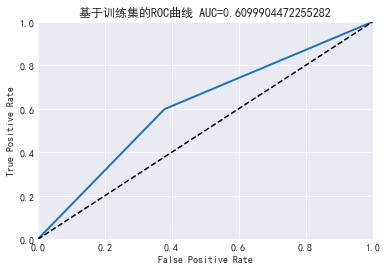

In [226]:
dtrain=xgb.DMatrix(X_train.values,label=y_train.values)
bst_tuned = xgb.Booster({'nthread': 4}) 
bst_tuned.load_model(r"E:\07_data\02_factor\temp_data\bst_tuned_{}.model".format(DATAID))
y_train_pred_prob = bst_tuned.predict(dtrain)
labels = dtrain.get_label()
y_train_pred = [1 if i > 0.5 else 0 for i in y_train_pred_prob]
print("Accuracy : %.4g" % metrics.accuracy_score(y_train, y_train_pred))
print("Roc : %.4g" % metrics.roc_auc_score(y_train, y_train_pred_prob))
fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
auc =  roc_auc_score(y_train, y_train_pred)
def plot_roc_curve(fpr, tpr, ds_type, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("基于{}的ROC曲线 AUC={}".format(ds_type, auc))
plot_roc_curve(fpr, tpr, "训练集")
plt.show()

# 模型测试
- 查准率=0.5并不等价于随机猜测 假设一共有N只股票 从中抽取n只，有k只强势股
- 查准率等于0.5 意味着选出的n只股票中 有n/2只是强势股票 
- 在随机猜测情况下，任取一只股票，要么为强势股 要么为弱势股 猜对的概率为0.5，则n次猜测猜对的次数服从二项分布B(n,0.5) 可知当n足够大时，猜对次数大于等于一半的概率接近0.5

## 读入训练集

In [279]:
f = open(r"E:\07_data\02_factor\datasets\df_test.txt", 'rb')  
df_test = pickle.load(f)[DATAID]
f.close()

f = open(r"E:\07_data\02_factor\feature_select\selected_feats_{}.txt".format(DATAID), 'rb')
selected_feats = pickle.load(f)

X_train = pd.read_csv(r"E:\07_data\02_factor\datasets\X_train_{}.csv".format(DATAID), index_col=0)
# X_train = X_train[selected_feats]
y_train = pd.read_csv(r"E:\07_data\02_factor\datasets\y_train_{}.csv".format(DATAID), index_col=0, header=None)

## 测试集预处理

In [280]:
f = open(r"E:\07_data\02_factor\preprocessing\std_info_{}.txt".format(DATAID), 'rb')  
std_info=pickle.load(f)  

df_test = df_test.set_index(['sec_id', 'date'])
droplist = ['yearmonth', 'group_id', 'month_ret', 'date_available']
df_test = df_test.drop(droplist, axis=1)
df_test.iloc[:,:-1] = (df_test.iloc[:,:-1] - std_info['mean']) / std_info['std']
X_test = df_test.iloc[:,:-1]
# X_test = X_test[selected_feats]
y_test = df_test.iloc[:,-1].to_frame()

In [281]:
f = open(r"E:\07_data\02_factor\datasets\df_test.txt", 'rb')  
df_test = pickle.load(f)[DATAID]
f.close()
df_test = df_test.set_index(['sec_id', 'date'])

## 导入模型

In [197]:
# 指明测试模型
xgb_test = xgb.Booster({'nthread': 4}) 
xgb_test.load_model(r"E:\07_data\02_factor\model\bst0_{}.model".format(DATAID))
dtrain = xgb.DMatrix(X_train.values, label=y_train.values)
dtest = xgb.DMatrix(X_test.values, label=y_test.values)
# 预测
y_train_scores = xgb_test.predict(dtrain)
y_test_scores = xgb_test.predict(dtest)

## P-R曲线确定决策阈值

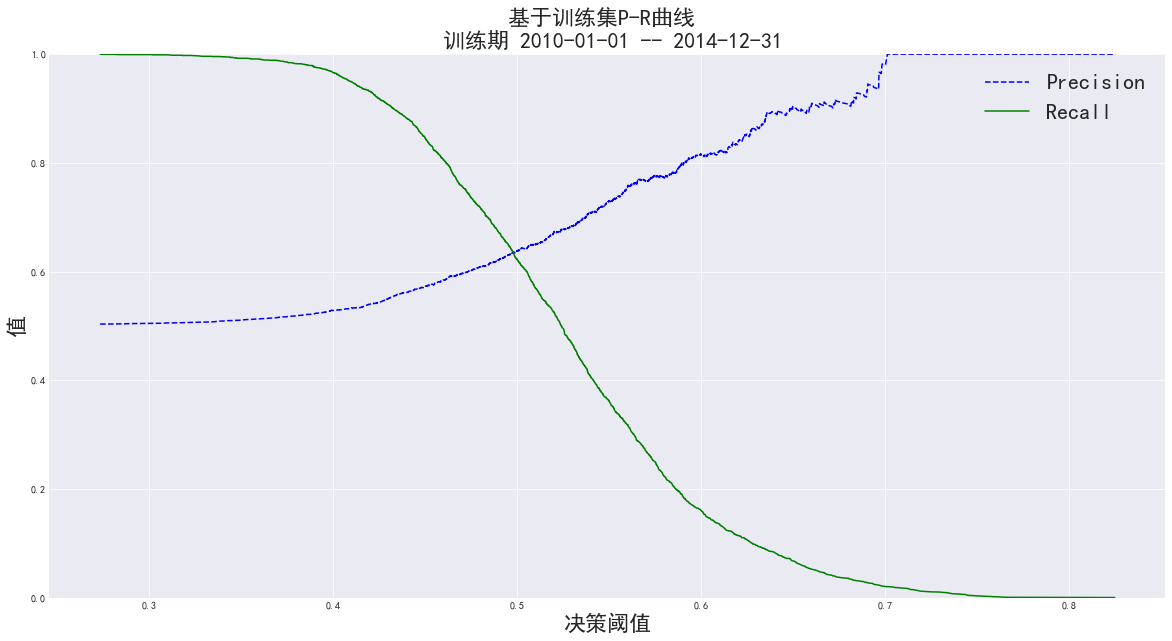

Best threshold= 0.696716
最佳阈值下的precision=0.9508196721311475 recall=0.023311897106109324


In [42]:
precisions, recalls, thresholds = metrics.precision_recall_curve(y_train, y_train_scores)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
ax.legend(fontsize=22)
plt.title("基于训练集P-R曲线 \n 训练期 2010-01-01 -- 2014-12-31", fontsize=22)
plt.xlabel("决策阈值", fontsize=22)
plt.ylabel("值",  fontsize=22)
plt.show()

# 根据业务要求确定最佳决策阈值
ix, iv = False, False
for i, v in enumerate(precisions[:-1]): # precisons最后一个元素必为1 会比thresholds多一个元素
    if (v > 0.95) and  ((y_train_scores > thresholds[i]).sum() > 20):
        if not ix:
            ix = i
            iv = v
        elif v < iv:
            ix = i
            iv = v
if (not ix):
    print("不能找到满足条件的阈值")
best_threshold = thresholds[ix]
print("Best threshold=", best_threshold)
print("最佳阈值下的precision={} recall={}".format(precisions[ix], recalls[ix]))
best_threshold = 0.5
# 训练集上的表现
y_train_scores = xgb_test.predict(dtrain)
y_train_pred = (y_train_scores > best_threshold)

# 测试集上的表现
y_test_scores = xgb_test.predict(dtest)
y_test_pred = (y_test_scores > best_threshold)

## 阈值调整后的precision

In [56]:
print("训练集上的准确率：", metrics.precision_score(y_train, y_train_pred))
print("测试集上的准确率：", metrics.precision_score(y_test, y_test_pred))

训练集上的准确率： 0.636400986031
测试集上的准确率： 0.519759450172


## ROC曲线

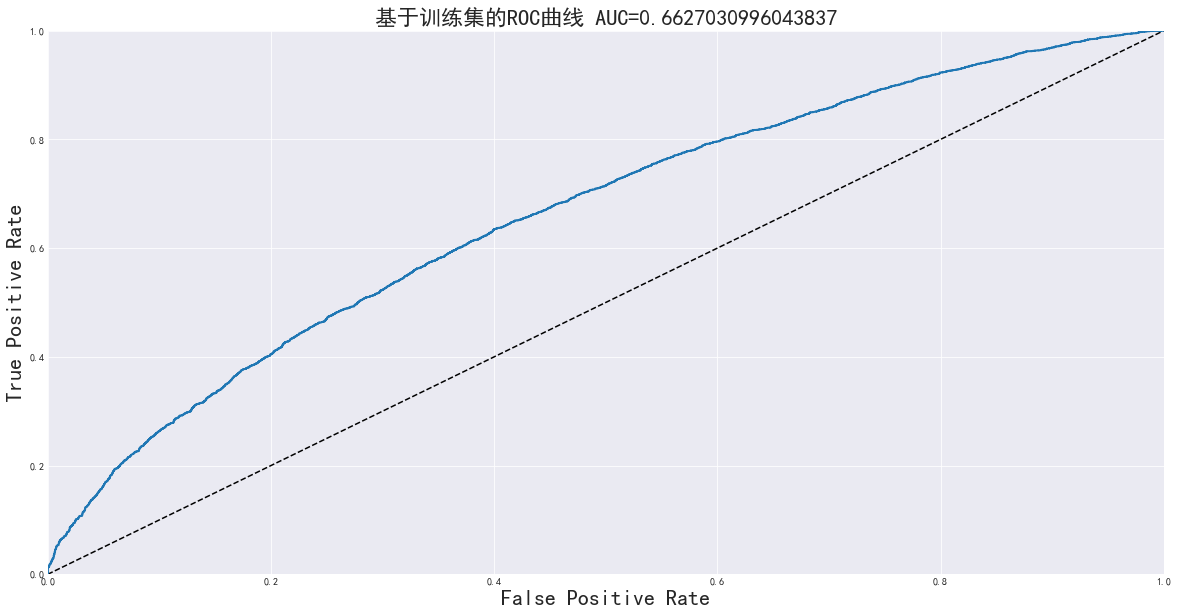

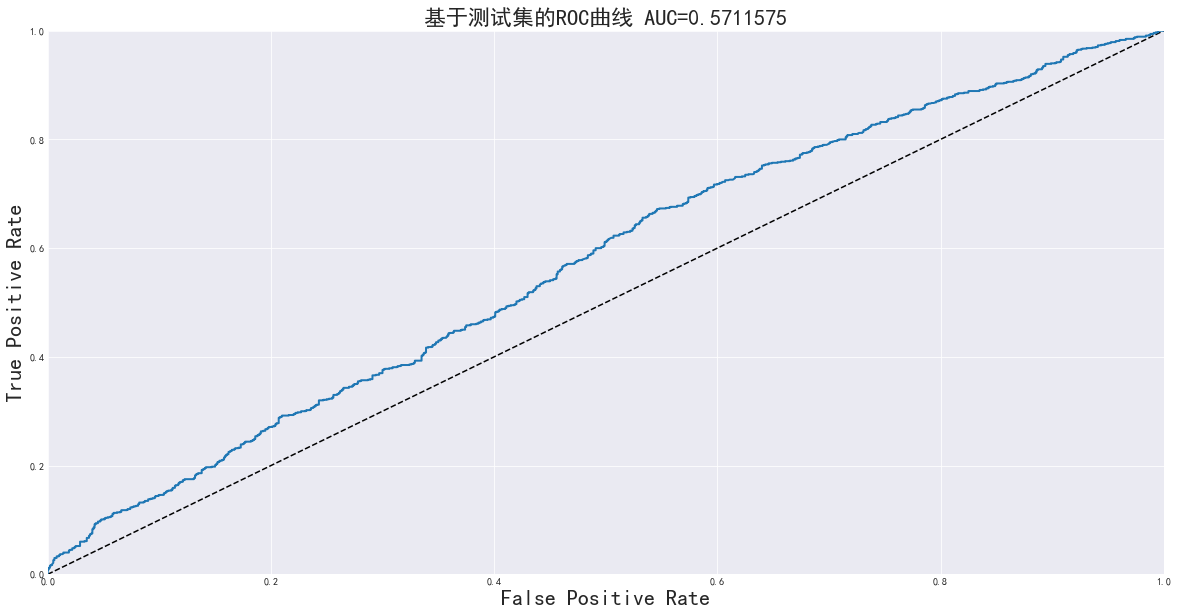

In [198]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_train_scores)
auc =  metrics.roc_auc_score(y_train, y_train_scores)
def plot_roc_curve(fpr, tpr, ds_type, label=None):
    fig, ax = plt.subplots()
    fig.set_size_inches(20, 10)
    ax.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    ax.plot(fpr, tpr, linewidth=2, label=label)
    plt.xlabel('False Positive Rate', fontsize=22)
    plt.ylabel('True Positive Rate', fontsize=22)
    plt.title("基于{}的ROC曲线 AUC={}".format(ds_type, auc), fontsize=22)

plot_roc_curve(fpr, tpr, "训练集")
plt.savefig(r"E:\07_data\02_factor\model\ROC_TRAIN_{}".format(DATAID))
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_scores)
auc =  metrics.roc_auc_score(y_test, y_test_scores)
plot_roc_curve(fpr, tpr, "测试集")
plt.savefig(r"E:\07_data\02_factor\model\ROC_TEST_{}".format(DATAID))


In [231]:
close = factor.get_secs_index(index="close", trading_days=X_backtest.index.levels[1].tolist(), sec_ids=X_backtest.index.levels[0].tolist())
close = close.set_index(['sec_id', 'date'])
return_lib = close.sort_index(level='sec_id')

In [233]:
close = close.set_index(['sec_id', 'date'])

In [243]:
f = open(r"E:\07_data\02_factor\datasets\df_test.txt", 'rb')  
df_return = pickle.load(f)[DATAID][['sec_id', 'date', 'month_ret']]
f.close()
close = factor.get_secs_index(index="close", trading_days=X_backtest.index.levels[1].tolist(), sec_ids=X_backtest.index.levels[0].tolist())
df_return = df_return.merge(close, how='inner', on=['date', 'sec_id'])
df_return = df_return.set_index(['sec_id', 'date'])
df_return = df_return.sort_index(level='sec_id')

# 历史数据回测

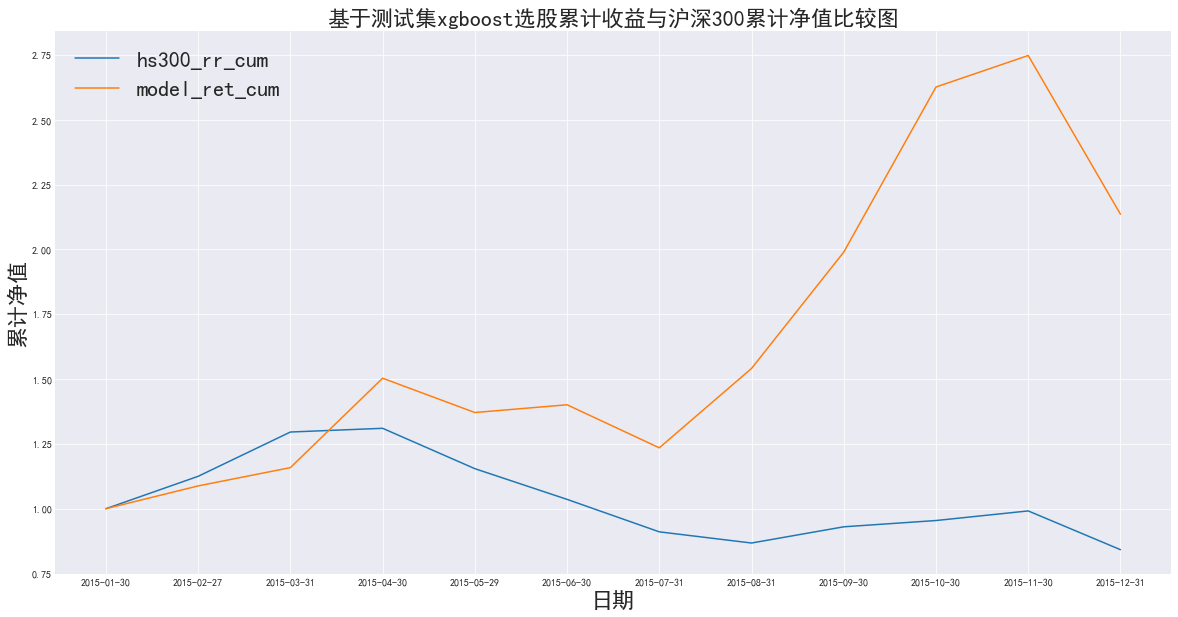

In [282]:
# xgb_test = xgb.Booster({'nthread': 4}) 
# xgb_test.load_model(r"E:\07_data\02_factor\model\bst0_{}.model".format(DATAID))
xgb_test = bst0
# 获取测试集
X_backtest = X_test.copy()
y_backtest = y_test.copy()
X_backtest = X_backtest.sort_index(level="sec_id")
y_backtest = y_backtest.sort_index(level="sec_id")

f = open(r"E:\07_data\02_factor\datasets\df_test.txt", 'rb')  
df_return = pickle.load(f)[DATAID][['sec_id', 'date', 'month_ret']]
f.close()
close = factor.get_secs_index(index="close", trading_days=X_backtest.index.levels[1].tolist(), sec_ids=X_backtest.index.levels[0].tolist())
df_return = df_return.merge(close, how='inner', on=['date', 'sec_id'])
df_return = df_return.set_index(['sec_id', 'date'])
df_return = df_return.sort_index(level='sec_id')

def derive_next_month_rr(sec_ids):
    """
    获取给定股票列表在给定日期列表的下个月收益率
    @sec_ids <list>: 股票列表
    """
    # 取月初月末的交易日列表
    tds = pd.read_csv(r"E:\07_data\02_factor\datasets\pre\trading_days.csv")
    tds['group'] = tds['date'].apply(lambda x: x[:7])
    tds = tds.sort_values(['date'])
    first = tds.groupby('group').head(1)
    last = tds.groupby('group').tail(1)
    tds=first.append(last)
    tds = tds.sort_values('date')

    # 获取月初月末交易日的收盘价
    close = factor.get_secs_index(index="close", trading_days=tds.date.tolist(), sec_ids=sec_ids)
    close = close.sort_values(['sec_id', 'date'])
    close['yearmonth'] = close['date'].apply(lambda x: x[:7])

    # 获取月收益率
    def cal_ret(x):
        close_id = x.columns.tolist().index('close')
        return x.iloc[-1, close_id]/x.iloc[0, close_id] - 1
    df_target=close.groupby(['sec_id', 'yearmonth'], as_index=False).apply(lambda x: cal_ret(x))
    df_target=df_target.reset_index().rename(columns={0: 'month_ret'})
    return df_target

# 计算持仓情况
NUM = 5
records = {}
for date in list(X_backtest.index.levels[1]):
    # 根据当前日期(月末)的特征计算选中的股票
    X_now =X_backtest.loc[(slice(None), date),:].copy()
    d_now = xgb.DMatrix(X_now.values)
    X_now['prob'] = xgb_test.predict(d_now)
    X_now = X_now.sort_values(['prob'])
    selected = X_now.iloc[-NUM:, -1].reset_index()['sec_id'].tolist()
    # 获得入选股票在下个月的收益率
    perform = df_return.loc[(selected, date), ['close', 'month_ret']]
    records[date] = (perform['close'] * perform['month_ret']).sum() / perform['close'].sum()
    
df_records = pd.DataFrame([[i, v] for i,v in records.items()], columns=['date', 'month_ret'])
df_records['yearmonth'] = df_records['date'].apply(lambda x: dk.date2char(dk.char2datetime(x) +  dk.timedelta({'months': 1}))[:7])
df_records = df_records.rename(columns={'month_ret': 'model_ret'})

# 获取基准收益
hs300_rr = derive_next_month_rr(['000300.SH'])
hs300_rr = hs300_rr.rename(columns={'month_ret': 'hs300_rr'})
del hs300_rr['sec_id']
df_records = df_records.merge(hs300_rr, how='left', on=['yearmonth'])
df_records_daily = df_records.copy()
# 获取模型和基准累计净值
for ix in df_records.index:
    if ix == 0:
        df_records.loc[ix, 'model_ret_cum'] = 1
        df_records.loc[ix, 'hs300_rr_cum'] = 1
    else:
        df_records.loc[ix, 'model_ret_cum'] = df_records.loc[ix-1, 'model_ret_cum'] * (1 + df_records.loc[ix, 'model_ret'])
        df_records.loc[ix, 'hs300_rr_cum'] = df_records.loc[ix-1, 'hs300_rr_cum'] * (1 + df_records.loc[ix, 'hs300_rr'])
df_records = df_records[['date', 'hs300_rr_cum', 'model_ret_cum']].set_index('date')
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
ax.plot(df_records)
ax.legend(df_records.columns, fontsize=22)
plt.title("基于测试集xgboost选股累计收益与沪深300累计净值比较图", fontsize=22)
plt.xlabel("日期", fontsize=22)
plt.ylabel("累计净值", fontsize=22)
plt.savefig(r"E:\07_data\02_factor\model\LJJZ_{}.png".format(DATAID))
# df_records[['date', 'hs300_rr_cum', 'model_ret_cum']].set_index('date').plot(title="基于测试集xgboost选股累计收益与hs300比较图")

In [183]:
# del df_records_daily['date']
# df_records_daily = df_records_daily.set_index(['yearmonth'])del df_records_daily['date']
# df_records_daily = df_records_daily.set_index(['yearmonth'])

# 年华收益率
rr_annually = (df_records.iloc[-1, :] - df_records.iloc[0, :]) / df_records.iloc[0, :]

# 夏普比率
# interest = pd.read_csv(r"E:\07_data\02_factor\temp_data\guo_bond_int_one_year.csv", encoding='utf-8')
# interest['year'] = interest['date'].apply(lambda x: str(x)[:4])
# del interest['date']
# interest = interest.groupby('year').mean() / 100
# interest_dict = interest.to_dict()['interest']
# dk.dict2json(interest_dict, r"E:\07_data\02_factor\datasets\pre\risk_free_int.json")
risk_free_int = dk.json2dict(r"E:\07_data\02_factor\datasets\pre\risk_free_int.json")

sharp_ratio = {}
sharp_ratio['model'] = (rr_annually['model_ret_cum'] - risk_free_int[ID2DATE[str(DATAID)]['TEST'][0][:4]]) / np.std(df_records_daily['model_ret'])
sharp_ratio['hs300'] = (rr_annually['hs300_rr_cum'] - risk_free_int[ID2DATE[str(DATAID)]['TEST'][0][:4]]) / np.std(df_records_daily['hs300_rr'])


# 最大回撤
max_back = {}
col_names = df_records.columns.tolist()
for i in range(df_records.shape[0]):
    for j in range(df_records.shape[1]):
        if i > 0:
            back = np.max(df_records.iloc[:i, j]) / df_records.iloc[i, j] - 1
            if back > 0: # 当前净值小于历史最大值：
                if back > max_back[col_names[j]]:
                    max_back[col_names[j]] = back
        else:
            max_back[col_names[j]] = 0
        
alpha =    df_records.iloc[-1, 1] - df_records.iloc[-1, 0]
info_ratio = (df_records_daily['model_ret'] - df_records_daily['hs300_rr']).mean() / (df_records_daily['model_ret'] - df_records_daily['hs300_rr']).std()

a1 = rr_annually.to_frame().T.rename(columns={"hs300_rr_cum": "hs300", "model_ret_cum": "model"})
a1['index'] = "年化收益率"
a2 = pd.DataFrame([[k,v] for k,v in max_back.items()]).set_index(0).T.rename(columns={"hs300_rr_cum": "hs300", "model_ret_cum": "model"})
a2['index'] = "最大回撤率"
a3 = pd.DataFrame([[k,v] for k,v in sharp_ratio.items()]).set_index(0).T
a3['index'] = "夏普比率"
df_metrics = a1.append(a2).append(a3)
df_metrics = df_metrics.append(pd.Series({'hs300': 0, 'model': info_ratio, 'index': "信息比率"}), ignore_index=True)
df_metrics = df_metrics.append(pd.Series({'hs300': 0, 'model': alpha, 'index': "超额收益率"}), ignore_index=True)
df_metrics['period'] = "{}--{}".format(ID2DATE[str(DATAID)]['TEST'][0], ID2DATE[str(DATAID)]['TEST'][1])
df_metrics = df_metrics.reindex(columns=[['period', 'index', 'hs300', 'model']])
df_metrics.to_csv(r"E:\07_data\02_factor\model\history_backtest_metrics_{}.csv".format(DATAID), index=0)
# print("模型年化收益率: ", rr_annually['model_ret_cum'])
# print("基准年化收益率: ", rr_annually['hs300_rr_cum'])
# print("模型超额收益率: ", alpha)
# print("模型最大回撤率: ", max_back['model_ret_cum'])
# print("基准最大回撤率: ", max_back['hs300_rr_cum'])
# print("模型夏普比率: ", sharp_ratio['model'])
# print("基准夏普比率: ", sharp_ratio['hs300'])
# print("模型信息比率: ", info_ratio)
df_metrics

,period,index,hs300,model
0,2015-01-01--2015-12-31,年化收益率,-0.158023,0.544127
1,2015-01-01--2015-12-31,最大回撤率,0.555943,0.282143
2,2015-01-01--2015-12-31,夏普比率,-1.879925,3.932826
3,2015-01-01--2015-12-31,信息比率,0.000000,0.616595
4,2015-01-01--2015-12-31,超额收益率,0.000000,0.702150


In [113]:
a1 = rr_annually.to_frame().T.rename(columns={"hs300_rr_cum": "hs300", "model_ret_cum": "model"})
a1['index'] = "年化收益率"
a2 = pd.DataFrame([[k,v] for k,v in max_back.items()]).set_index(0).T.rename(columns={"hs300_rr_cum": "hs300", "model_ret_cum": "model"})
a2['index'] = "最大回撤率"
a3 = pd.DataFrame([[k,v] for k,v in sharp_ratio.items()]).set_index(0).T
a3['index'] = "夏普比率"
df_metrics = a1.append(a2).append(a3)
df_metrics = df_metrics.append(pd.Series({'hs300': 0, 'model': info_ratio, 'index': "信息比率"}), ignore_index=True)
df_metrics = df_metrics.append(pd.Series({'hs300': 0, 'model': alpha, 'index': "超额收益率"}), ignore_index=True)
df_metrics['period'] = "{}--{}".format(ID2DATE[str(DATAID)]['TEST'][0], ID2DATE[str(DATAID)]['TEST'][1])
df_metrics = df_metrics.reindex(columns=[['period', 'index', 'hs300', 'model']])

In [90]:
a3 = pd.DataFrame([[k,v] for k,v in sharp_ratio.items()]).set_index(0).T
a3['index'] = "夏普比率"

In [98]:
pd.Series({'hs300': 0, 'model': info_ratio, 'index': "信息比率"})

hs300           0
index        信息比率
model    0.700043
dtype: object

In [105]:
df_metrics = df_metrics.append(pd.Series({'hs300': 0, 'model': info_ratio, 'index': "信息比率"}), ignore_index=True)
df_metrics = df_metrics.append(pd.Series({'hs300': 0, 'model': alpha, 'index': "超额收益率"}), ignore_index=True)
df_metrics = df_metrics.reindex(columns=[['index', 'hs300', 'model']])

In [114]:
df_metrics

,period,index,hs300,model
0,2015-01-01--2015-12-31,年化收益率,-0.158023,1.040543
1,2015-01-01--2015-12-31,最大回撤率,0.555943,0.275538
2,2015-01-01--2015-12-31,夏普比率,-1.879925,7.126121
3,2015-01-01--2015-12-31,信息比率,0.000000,0.700043
4,2015-01-01--2015-12-31,超额收益率,0.000000,1.198567


In [46]:
# del df_records_daily['date']
# df_records_daily = df_records_daily.set_index(['yearmonth'])del df_records_daily['date']
# df_records_daily = df_records_daily.set_index(['yearmonth'])

# 年华收益率
rr_annually = (df_records.iloc[-1, :] - df_records.iloc[0, :]) / df_records.iloc[0, :]

# 夏普比率
interest = pd.read_csv(r"E:\07_data\02_factor\temp_data\guo_bond_int_one_year.csv", encoding='utf-8')
interest['year'] = interest['date'].apply(lambda x: str(x)[:4])
del interest['date']
interest = interest.groupby('year').mean() / 100

sharp_ratio = {}
sharp_ratio['model'] = (rr_annually['model_ret_cum'] - interest.loc['2015', 'interest']) / np.std(df_records_daily['model_ret'])
sharp_ratio['hs300'] = (rr_annually['hs300_rr_cum'] - interest.loc['2015', 'interest']) / np.std(df_records_daily['hs300_rr'])


# 最大回撤
max_back = {}
col_names = df_records.columns.tolist()
for i in range(df_records.shape[0]):
    for j in range(df_records.shape[1]):
        if i > 0:
            back = np.max(df_records.iloc[:i, j]) / df_records.iloc[i, j] - 1
            if back > 0: # 当前净值小于历史最大值：
                if back > max_back[col_names[j]]:
                    max_back[col_names[j]] = back
        else:
            max_back[col_names[j]] = 0
        
alpha =    df_records.iloc[-1, 1] - df_records.iloc[-1, 0]
info_ratio = (df_records_daily['model_ret'] - df_records_daily['hs300_rr']).mean() / (df_records_daily['model_ret'] - df_records_daily['hs300_rr']).std()
print("模型年化收益率: ", rr_annually['model_ret_cum'])
print("基准年化收益率: ", rr_annually['hs300_rr_cum'])
print("模型超额收益率: ", alpha)
print("模型最大回撤率: ", max_back['model_ret_cum'])
print("基准最大回撤率: ", max_back['hs300_rr_cum'])
print("模型夏普比率: ", sharp_ratio['model'])
print("基准夏普比率: ", sharp_ratio['hs300'])
print("模型信息比率: ", info_ratio)

模型年化收益率:  0.0251303965308
基准年化收益率:  -0.255487974919
模型超额收益率:  0.28061837145
模型最大回撤率:  0.353876200805
基准最大回撤率:  0.439867409616
模型夏普比率:  -0.00379995504801
基准夏普比率:  -5.19253687944
模型信息比率:  0.5927667618527293


# 超级代码定义

In [2]:
def superfunc(DATAID, NUM):
    ID2DATE = dk.json2dict(r"E:\07_data\02_factor\ID2DATE.json")
    # 获得训练集
    f = open(r"E:\07_data\02_factor\datasets\df_train.txt", 'rb') 
    df_train = pickle.load(f)
    f.close()
    df_train = df_train[DATAID]
    # 删除不需要的临时变量
    droplist = ['sec_id', 'yearmonth', 'month_ret', 'group_id', 'date', 'date_available']
    df_train = df_train.drop(droplist, axis=1)
    # 分离特征和标签¶
    X_train = df_train.iloc[:, :-1]
    y_train = df_train.iloc[:, -1]

    # 训练集清洗
    X_train = alpha.api.wash_train_data(df_train=X_train, DATAID=DATAID, recalculate=False)

    #训练xgboost模型
    params = {'max_depth': 2, 'eta': 0.05, 'silent': 1, 'objective': 'binary:logistic', 'eval_metric':'auc'}
    # num_boost_round必须放在xgb.train语句中 放在params中无效 并且该参数是一个重要参数
    bst = alpha.api.XGB_classfier_fit(X_train, y_train, params, DATAID, 200, refit= False)

    # 读入测试集
    f = open(r"E:\07_data\02_factor\datasets\df_test.txt", 'rb')  
    df_test = pickle.load(f)[DATAID]
    f.close()
    df_test = df_test.set_index(['sec_id', 'date'])
    X_test = df_test.iloc[:,:-1]
    y_test = df_test.iloc[:,-1].to_frame()


    # 测试集预处理
    droplist = ['yearmonth', 'group_id', 'month_ret', 'date_available']
    X_test = X_test.drop(droplist, axis=1)
    X_test = alpha.api.wash_test_data(df_test=X_test, DATAID=DATAID)
    y_train_scores = alpha.api.XGB_classfier_predict_prob(bst, X_train)
    y_test_scores = alpha.api.XGB_classfier_predict_prob(bst, X_test)
    alpha.api.plot_roc_curve(y_train, y_train_scores, "训练集", DATAID)
    alpha.api.plot_roc_curve(y_test, y_test_scores, "测试集", DATAID)

    # 获得每月选中股票
    selected_stocks = {}
    X_test = X_test.sort_index(level="sec_id")
    for date in list(X_test.index.levels[1]):
        # 根据当前日期(月末)的特征计算选中的股票
        X_now = X_test.loc[(slice(None), date),:].copy()
        X_now['prob'] = alpha.api.XGB_classfier_predict_prob(bst, X_now)
        X_now = X_now.sort_values(['prob'])
        selected = X_now.iloc[-NUM:, -1].reset_index()['sec_id'].tolist()
        yearmonth = dk.date2char(dk.char2datetime(date) +  dk.timedelta({'months': 1}))[:7]
        selected_stocks[yearmonth] = selected

    # 历史数据回测 并计算相关回测指标
    alpha.api.backtest_for_mfs(selected_stocks, DATAID, "hs300", "XGBoost")

# 超级函数调用

STD_INFO has already existed
MODEL has already been fitted
                   period  index  benchmark     model
0  2014-01-01--2014-12-31  年化收益率   0.493572  0.916318
1  2014-01-01--2014-12-31  最大回撤率   0.060317  0.156622
2  2014-01-01--2014-12-31   夏普比率   5.764226  9.146868
3  2014-01-01--2014-12-31   信息比率   0.000000  0.184434
4  2014-01-01--2014-12-31  超额收益率   0.000000  0.422746


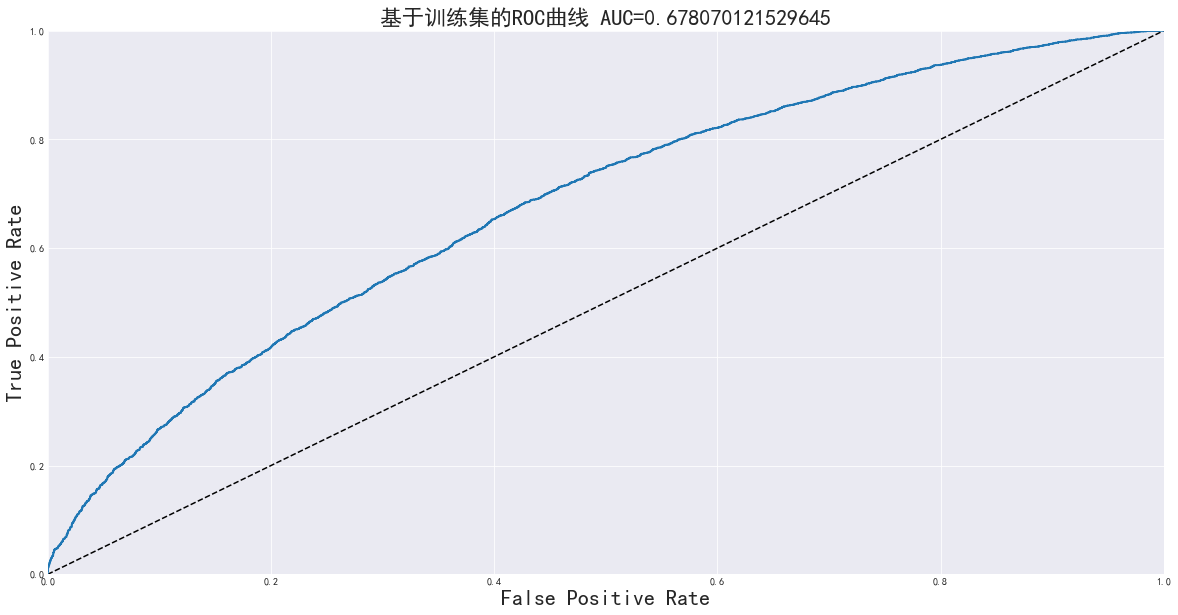

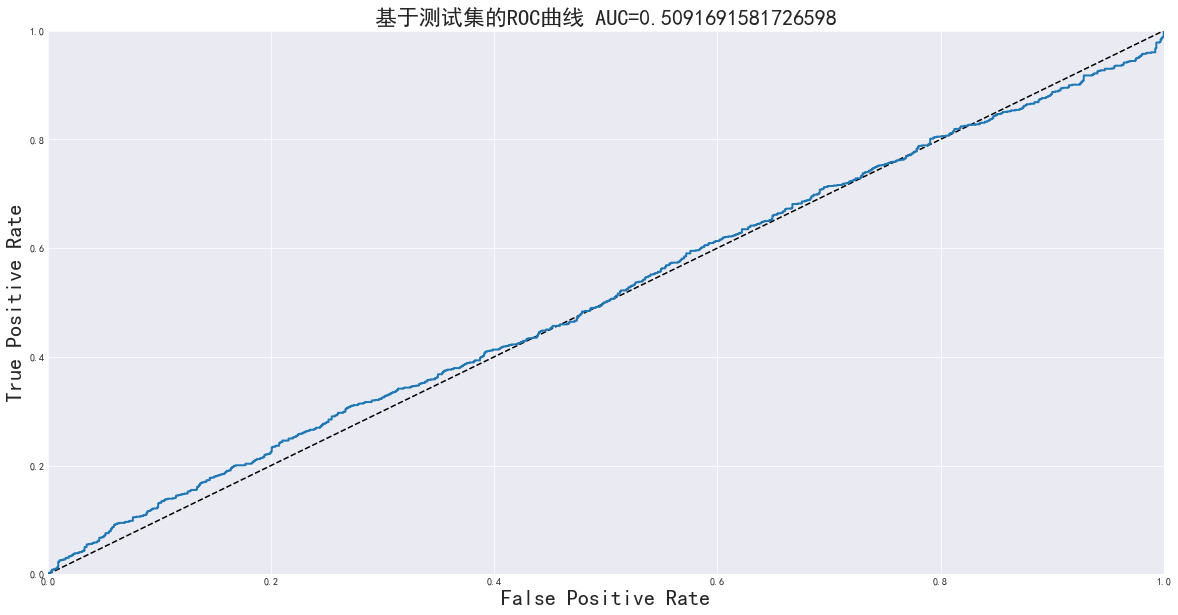

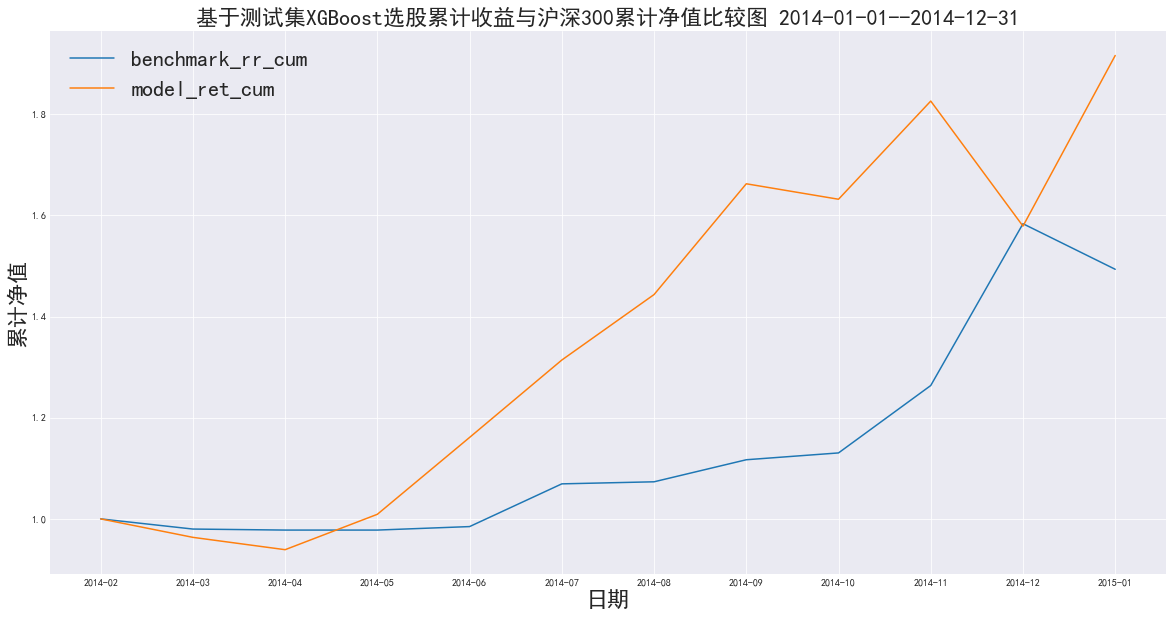

In [6]:
superfunc(DATAID=4, NUM=5)

In [173]:
def derive_next_month_rr(sec_ids, start_date, end_date):
    """
    获取给定股票列表在给定日期列表的下个月收益率
    @sec_ids <list>: 股票列表
    @start_date <"%Y-%m-%d">: 开始日期
    @end_date <"%Y-%m-%d">: 结束日期
    @return dataframe [sec_id yearmonth month_ret CLOSE]
    """
    # 取月初月末的交易日列表
    tds = pd.read_csv(r"E:\07_data\02_factor\datasets\pre\trading_days.csv")
    tds = tds[tds.date.between(start_date, end_date)]
    tds['group'] = tds['date'].apply(lambda x: x[:7])
    tds = tds.sort_values(['date'])
    first = tds.groupby('group').head(1)
    last = tds.groupby('group').tail(1)
    tds = first.append(last)
    tds = tds.sort_values('date')

    # 获取月初月末交易日的收盘价
    close = DataAPI.api.get_secs_indicator_on_multidays(indicator="CLOSE", trading_days=tds.date.tolist(), sec_ids=sec_ids)
    close = close.sort_values(['sec_id', 'date'])
    close['yearmonth'] = close['date'].apply(lambda x: x[:7])

    # 获取月收益率
    def cal_ret(x):
        close_id = x.columns.tolist().index('CLOSE')
        return x.iloc[-1, close_id] / x.iloc[0, close_id] - 1
    df_target = close.groupby(['sec_id', 'yearmonth'], as_index=False).apply(lambda x: cal_ret(x))
    df_target = df_target.reset_index().rename(columns={0: 'month_ret'})
    # 只取每个月月初的收盘价
    close = close.groupby(['sec_id', 'yearmonth'], as_index=False).apply(lambda x: x.head(1))
    df_target = df_target.merge(close, how='inner', on=['sec_id', 'yearmonth'])
    del df_target['date']
    return df_target


In [144]:
hs300_rr = derive_next_month_rr(['000300.SH'], "2006-01-01", "2018-12-31")

In [133]:
DataAPI.api.get_secs_indicator_on_multidays(indicator="CLOSE", trading_days=tds.date.tolist(), sec_ids=sec_ids)

NameError: name 'sec_ids' is not defined

In [50]:
close = DataAPI.api.get_secs_indicator_on_multidays(indicator="CLOSE", trading_days=['2017-05-15', '2017-05-16'], sec_ids=['000009.SZ', '000021.SZ'])
close = close.sort_values(['sec_id', 'date'])
close['yearmonth'] = close['date'].apply(lambda x: x[:7])

In [84]:
DataAPI.api.get_secs_indicator_on_multidays??

In [7]:
f = open(r"E:\07_data\02_factor\datasets\df_test.txt", 'rb')  
df_test = pickle.load(f)[2]
f.close()

In [12]:
tds = pd.read_csv(r"E:\07_data\02_factor\datasets\pre\trading_days.csv")

In [174]:
A_rr_monthly = derive_next_month_rr(['000300.SH'], "2006-01-01", "2018-12-31")

In [176]:
sec_ids_dict = {"all_A": [], "hs300_index": ['000300.SH'], "zz500_index": ['000905.SH'], "wind_ALL_A_index": ['881001.WI']}
for k,v in sec_ids_dict.items():
    a1 = derive_next_month_rr(v, "2006-01-01", "2018-12-31")
    a1.to_csv(r"E:\07_data\02_factor\datasets\return_rate\{}_rr_monthly.csv".format(k), index=0)

In [193]:
benchmark = "zz500"
benchmark_rr = pd.read_csv(r"E:\07_data\02_factor\datasets\return_rate\{}_index_rr_monthly.csv".format(benchmark))
benchmark_rr = benchmark_rr.rename(columns={'month_ret': 'benchmark_rr'})
del benchmark_rr['CLOSE']
benchmark_rr

,sec_id,yearmonth,benchmark_rr
0,000905.SH,2006-01,0.098720
1,000905.SH,2006-02,-0.016499
2,000905.SH,2006-03,0.028994
3,000905.SH,2006-04,0.112983
4,000905.SH,2006-05,0.187684
5,000905.SH,2006-06,0.020783
6,000905.SH,2006-07,-0.058798
7,000905.SH,2006-08,0.050392
8,000905.SH,2006-09,0.068083
9,000905.SH,2006-10,-0.023983


In [184]:
hs300 = hs300.set_index(['sec_id', 'yearmonth'])
hs300 = hs300.sort_index(level='sec_id')

In [190]:
hs300_rr

,sec_id,yearmonth,hs300_rr
0,000300.SH,2006-01,0.072410
1,000300.SH,2006-02,0.019140
2,000300.SH,2006-03,0.004230
3,000300.SH,2006-04,0.086188
4,000300.SH,2006-05,0.120651
5,000300.SH,2006-06,-0.006356
6,000300.SH,2006-07,-0.088712
7,000300.SH,2006-08,0.044177
8,000300.SH,2006-09,0.064613
9,000300.SH,2006-10,0.019775


In [20]:
sec_ids_rr = derive_next_month_rr(sec_ids['sec_id'].tolist())

In [16]:
sec_ids = pd.read_csv(r"E:\07_data\02_factor\datasets\pre\sec_ids.csv")

In [29]:
sec_ids_rr.to_csv(r"E:\07_data\02_factor\datasets\pre\sec_ids_month_rr.csv", index=0)

In [27]:
sec_ids_rr['yearmonth'][0]

'2005-01'

In [120]:
DataAPI.api.get_secs_indicator_on_multidays(indicator="CLOSE", trading_days=['2018-06-26', '2018-06-27', '2018-06-25'], sec_ids=['881001.WI'])

,sec_id,CLOSE,date
0,881001.WI,3846.6861,2018-06-26
0,881001.WI,3794.4735,2018-06-27
0,881001.WI,3846.6151,2018-06-25


In [63]:
a

,sec_id,CLOSE,date
